In [3]:
from typing import Optional
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as tkr
from src.train.plots import Line
from src.processes.observables import Observable
import warnings

## Setup

In [12]:
plt.rc("font", family="serif", size=16)
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

COLORS = [f"C{i}" for i in range(10)]
COLORS_exp = ["#b30000", "#7c1158", "#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e", "#ebdc78"]

RECO_COLOR = COLORS[0]
HARD_COLOR = COLORS[1]
HERWIG_RECO_COLOR = COLORS_exp[0]
HERWIG_HARD_COLOR = COLORS_exp[1]
AFF_INN_COLOR = COLORS[2]
INN_COLOR = "firebrick"
CFM_COLOR = COLORS_exp[3]
P_DIDI_COLOR = "forestgreen"
UP_DIDI_COLOR = "darkorchid"
SB_COLOR = COLORS[2]
OMNI_COLOR = COLORS[8]

axes_labels_fontsize = 25
mpl.rcParams['font.size'] = 26 # 17 for SB on second panel
                               # larger for migration like 22








def hist_plot(
    pdf: PdfPages,
    lines: list[Line],
    bins: np.ndarray,
    observable: Observable,
    show_ratios: bool = True,
    title: Optional[str] = None,
    no_scale: bool = False,
    yscale: Optional[str] = None,
    show: bool = False,
    rect = None,
    ylabel = "Normalized",
    xlim = None,
    ylim = None,
    legend_kwargs = {},
    legend_callback = None,
    n_unfoldings = 1,
    bayesian = False,
    plot_SB_on_second_panel = False,
):
    """
    Makes a single histogram plot, used for the observable histograms and clustering
    histograms.
    Args:
        pdf: Multipage PDF object
        lines: List of line objects describing the histograms
        bins: Numpy array with the bin boundaries
        show_ratios: If True, show a panel with ratios
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        n_panels = 1 + int(show_ratios) + int(plot_SB_on_second_panel)
        fig, axs = plt.subplots(
            n_panels,
            1,
            sharex=True,
            figsize=(8.5, 7),
            gridspec_kw={"height_ratios": (3, 1, 1)[:n_panels], "hspace": 0.00},
        )
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
        if n_panels == 1:
            axs = [axs]

        for line in lines:
            if line.vline:
                axs[0].axvline(line.y, label=line.label, color=line.color)
                continue
            integral = np.sum((bins[1:] - bins[:-1]) * line.y)
            scale = 1 / integral if integral != 0.0 else 1.0
            if line.y_ref is not None:
                ref_integral = np.sum((bins[1:] - bins[:-1]) * line.y_ref)
                ref_scale = 1 / ref_integral if ref_integral != 0.0 else 1.0
            if no_scale:
                scale = 1.
                ref_scale = 1.
            if not bayesian and line.y_err is not None:
                downweight_unfolds = np.sqrt(n_unfoldings) if "DiDi" in line.label or "INN" in line.label or "CFM" in line.label else 1
            elif line.y_err is not None:
                downweight_unfolds = 1
            else:
                downweight_unfolds = 0
            print("Weights for Unc. of unfolds", downweight_unfolds)
            hist_line(
                axs[0],
                bins,
                line.y * scale,
                line.y_err * scale * downweight_unfolds if line.y_err is not None else None,
                label=line.label,
                color=line.color,
                fill=line.fill,
                linestyle=line.linestyle
            )

            if line.y_ref is not None:
                ratio = (line.y * scale) / (line.y_ref * ref_scale)
                #print(ratio)
                ratio_isnan = np.isnan(ratio) | np.isinf(ratio)
                if line.y_err is not None:
                    
                    if len(line.y_err.shape) == 2:
                        ratio_err = (line.y_err * scale) / (line.y_ref * ref_scale)
                        ratio_err[:, ratio_isnan] = 0.0
                        ratio_err = downweight_unfolds * ratio_err
                    else:
                        ratio_err = np.sqrt((line.y_err / line.y) ** 2)
                        ratio_err[ratio_isnan] = 0.0
                        ratio_err = downweight_unfolds * ratio_err
                else:
                    ratio_err = None
                ratio[ratio_isnan] = 1.0
                if not plot_SB_on_second_panel or "SB" not in line.label:
                    hist_line(
                        axs[1], bins, ratio, ratio_err, label=None, color=line.color
                    )
                elif plot_SB_on_second_panel and "SB" not in line.label:
                    hist_line(
                        axs[1], bins, ratio, ratio_err, label=None, color=line.color
                    )
                else:
                    hist_line(
                        axs[2], bins, ratio, ratio_err, label=None, color=line.color
                    )

        if legend_callback is not None:
            legend_callback(axs)
        
        if "Jet mass" in observable.tex_label:
            axs[0].legend(frameon=False, **legend_kwargs)
        axs[0].set_ylabel(ylabel)
        axs[0].set_yscale(observable.yscale if yscale is None else yscale)
        if ylim is not None:
            axs[0].set_ylim(*ylim)
        #if title is not None:
        #    self.corner_text(axs[0], title, "left", "top")

        if show_ratios:
            axs[1].set_ylabel(r"$\frac{\mathrm{Model}}{\mathrm{Truth}}$")
            axs[1].set_yticks([0.95, 1, 1.05])
            axs[1].set_ylim([0.9, 1.1])
            axs[1].axhline(y=1, c="black", ls="--", lw=0.7)
            axs[1].axhline(y=1.1, c="black", ls="dotted", lw=0.5)
            axs[1].axhline(y=0.9, c="black", ls="dotted", lw=0.5)
            if plot_SB_on_second_panel:
                axs[2].set_ylabel(r"$\frac{\mathrm{Model}}{\mathrm{Truth}}$")
                axs[2].set_yticks([0.95, 1, 1.05])
                axs[2].set_ylim([0.9, 1.1])
                axs[2].axhline(y=1, c="black", ls="--", lw=0.7)
                axs[2].axhline(y=1.1, c="black", ls="dotted", lw=0.5)
                axs[2].axhline(y=0.9, c="black", ls="dotted", lw=0.5)

        unit = "" if observable.unit is None else f" [{observable.unit}]"
        axs[-1].set_xlabel(f"${{{observable.tex_label}}}${unit}")
        axs[-1].set_xscale(observable.xscale)
        if xlim is None:
            axs[-1].set_xlim(bins[0], bins[-1])
        else:
            axs[-1].set_xlim(*xlim)

        plt.savefig(pdf, format="pdf")
        if show:
            plt.show()
        plt.close()

def hist_line(
    ax: mpl.axes.Axes,
    bins: np.ndarray,
    y: np.ndarray,
    y_err: np.ndarray,
    label: str,
    color: str,
    linestyle: str = "solid",
    fill: bool = False,
):
    """
    Plot a stepped line for a histogram, optionally with error bars.
    Args:
        ax: Matplotlib Axes
        bins: Numpy array with bin boundaries
        y: Y values for the bins
        y_err: Y errors for the bins
        label: Label of the line
        color: Color of the line
        linestyle: line style
        fill: Filled histogram
    """

    dup_last = lambda a: np.append(a, a[-1])

    if fill:
        ax.fill_between(
            bins, dup_last(y), label=label, facecolor=color, step="post", alpha=0.2
        )
    else:
        ax.step(
            bins,
            dup_last(y),
            label=label,
            color=color,
            linewidth=1.5,
            where="post",
            ls=linestyle,
        )
    if y_err is not None:
        if len(y_err.shape) == 2:
            y_low = y_err[0]
            y_high = y_err[1]
        else:
            y_low = y - y_err
            y_high = y + y_err

        ax.step(
            bins,
            dup_last(y_high),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.step(
            bins,
            dup_last(y_low),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.fill_between(
            bins,
            dup_last(y_low),
            dup_last(y_high),
            facecolor=color,
            alpha=0.3,
            step="post",
        )

## Pythia Observables Plots (NON-BAYESIAN MODELS)

In [825]:
route_CFM = "plots/CFM/20231213_174452_update-long"
route_P_DIDI = "plots/DiDi_paired/20231213_174523_update-long"
route_UP_DIDI = "plots/DiDi_unpaired/20231213_174540_update-long"
route_INN = "plots/RQS_cINN/20231213_174414_update-long"

routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_all = []
for route in routes:
    with open(route + "/observables_comparison.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/final/"

10 UNFOLDINGS


Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


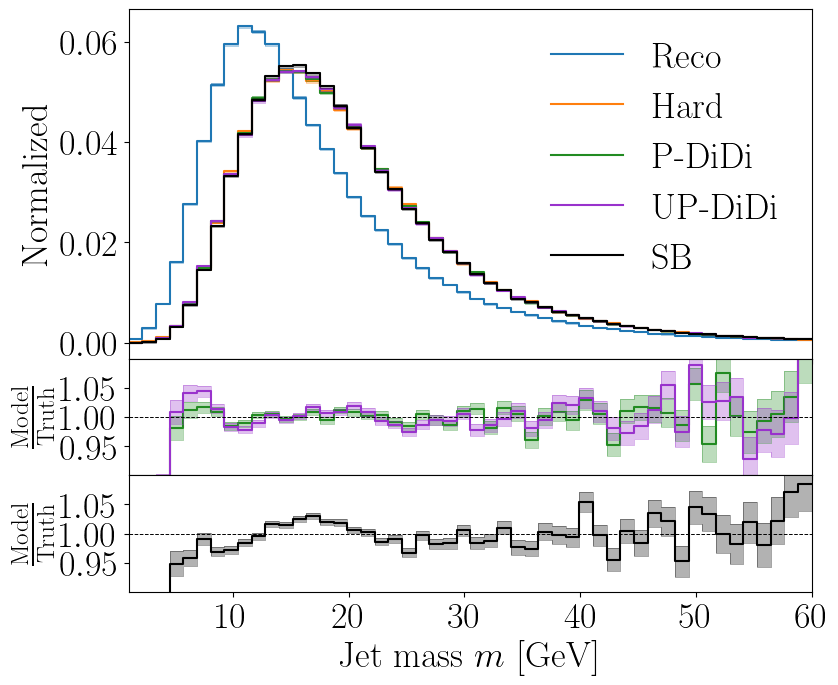

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


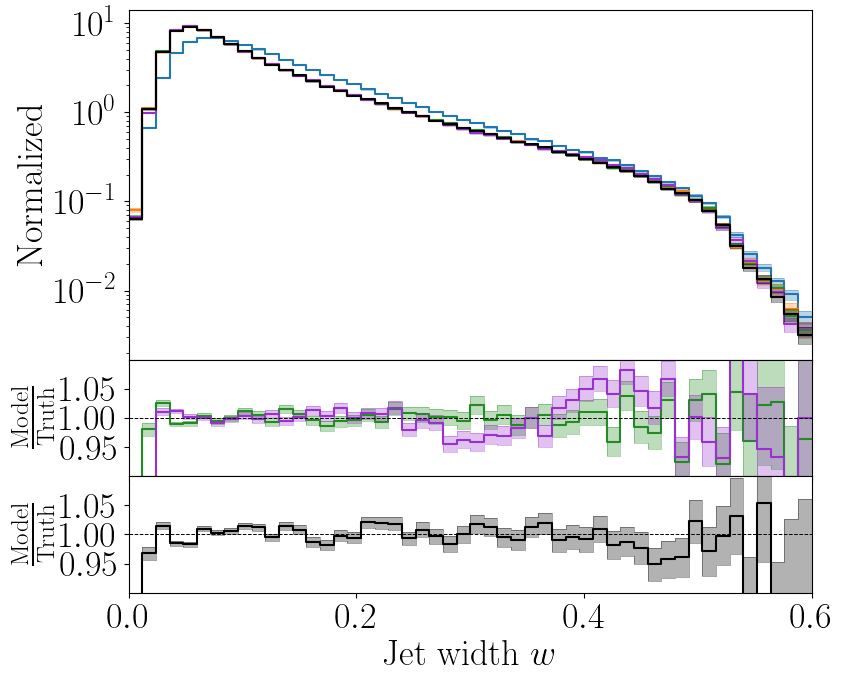

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


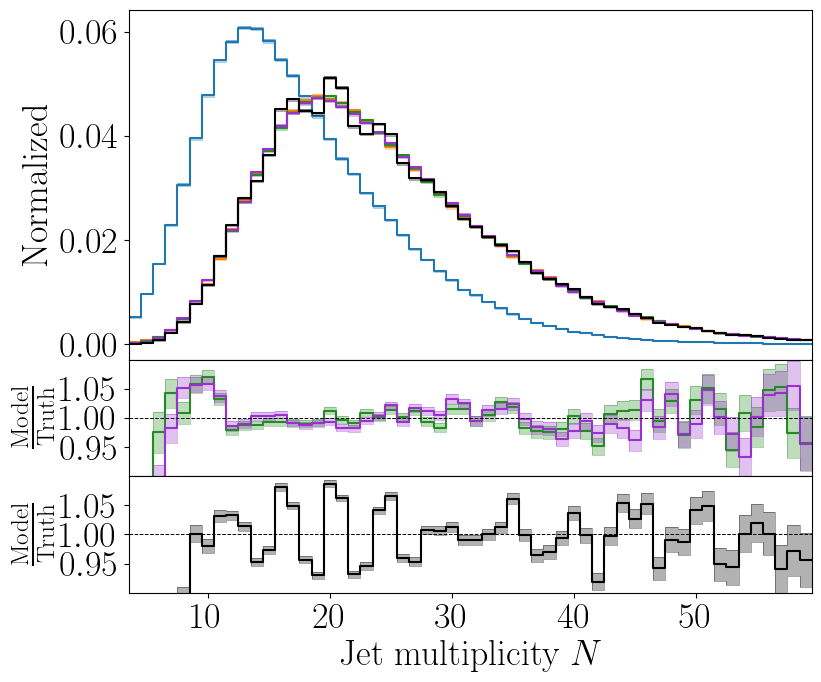

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


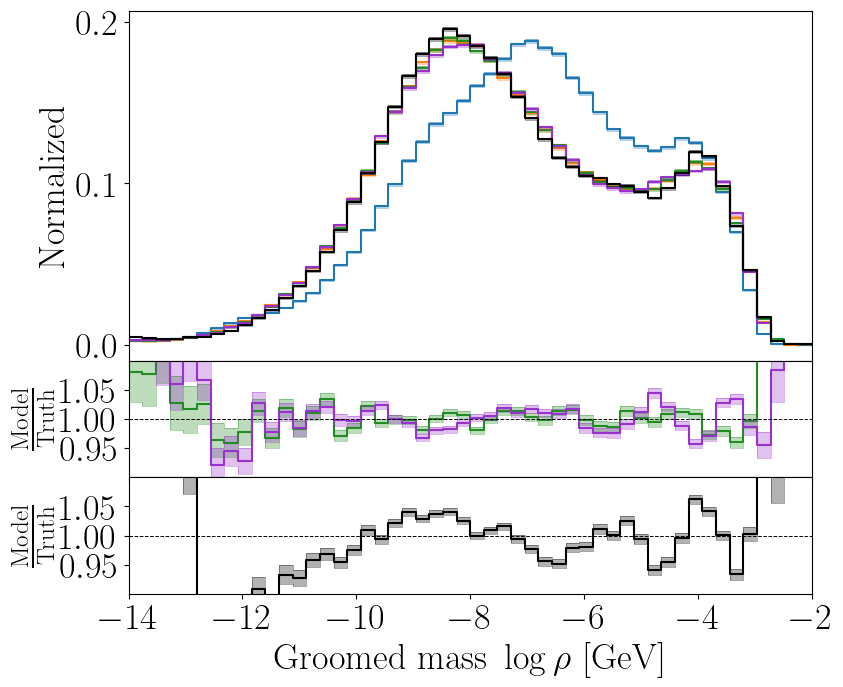

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


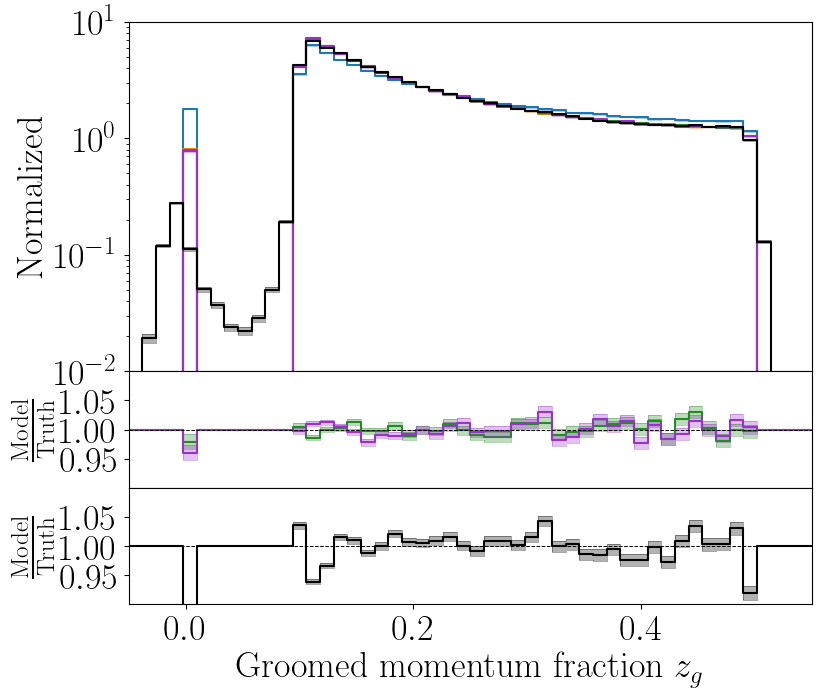

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 1


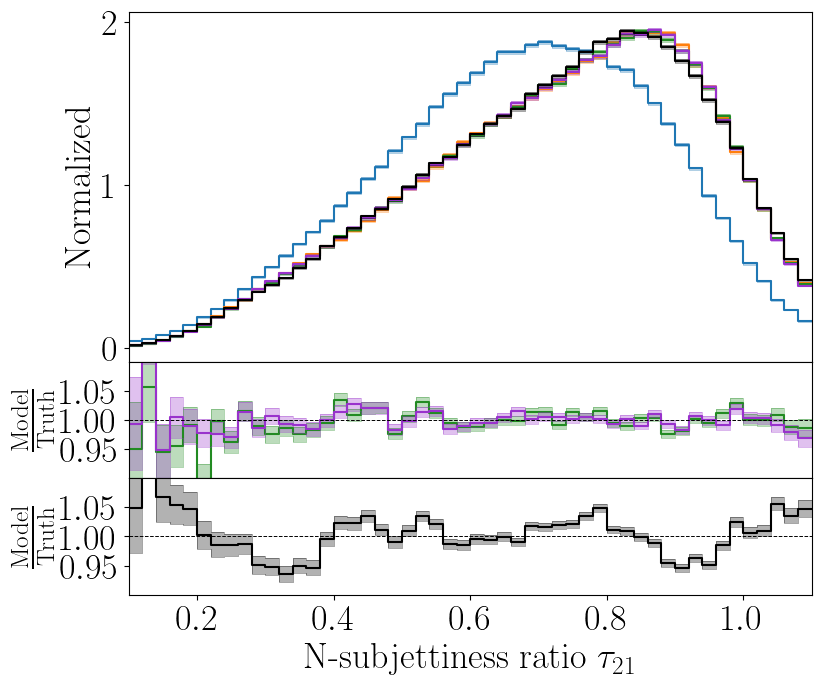

In [826]:
comparison_P_DIDI = comparison_all[1]
comparison_UP_DIDI = comparison_all[2]

with PdfPages(final_route + "observables-SB_DiDi-second_panel.pdf") as pp:
    for observable_P_DIDI, observable_UP_DIDI in zip(comparison_P_DIDI, comparison_UP_DIDI):

        
        # Reco
        line_reco = observable_P_DIDI["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_P_DIDI["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDi paired
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "P-DiDi"
        
        # DiDi unpaired
        obs_UP_DIDI = observable_UP_DIDI["obs"]
        bins_UP_DIDI = observable_UP_DIDI["bins"]
        line_UP_DIDI = observable_UP_DIDI["lines"][3]
        line_UP_DIDI.color = UP_DIDI_COLOR
        line_UP_DIDI.label = "UP-DiDi"
        
        # SB
        line_SB = observable_P_DIDI["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_P_DIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_P_DIDI, line_UP_DIDI, line_SB],
            n_unfoldings=n_unfoldings,
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            bayesian=False,
            show_ratios=True,
            ylim=ylim,
            plot_SB_on_second_panel=True,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


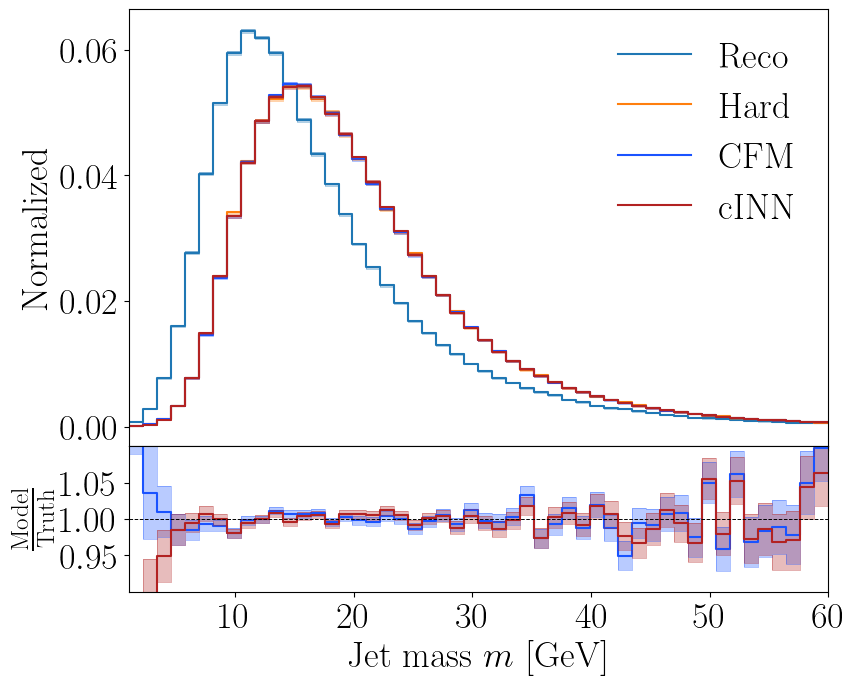

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


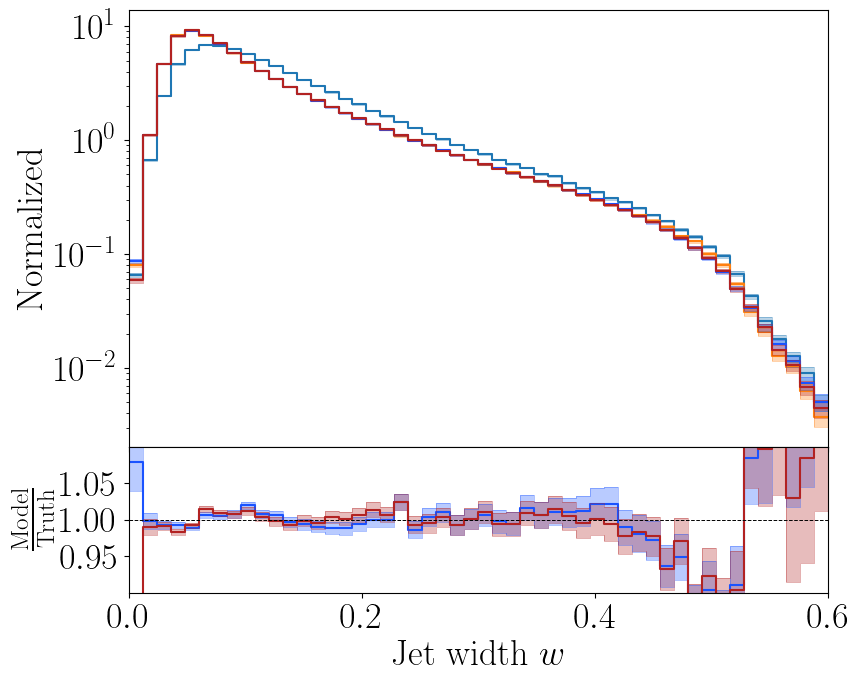

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


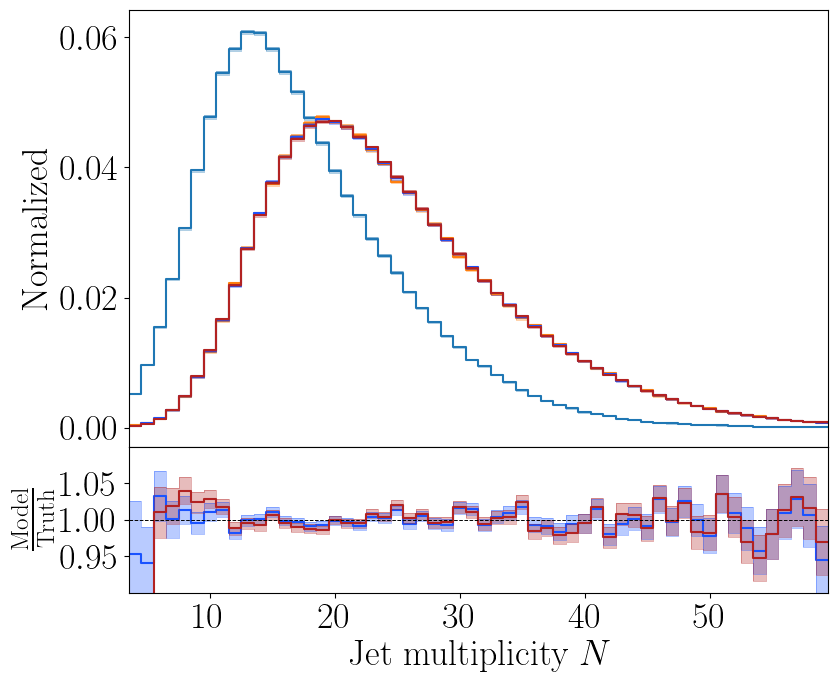

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


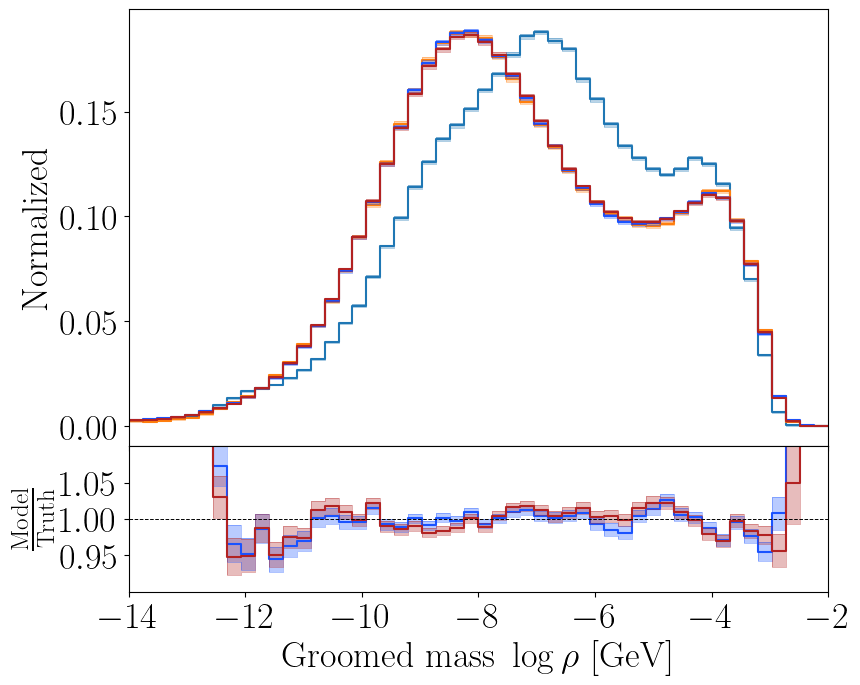

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


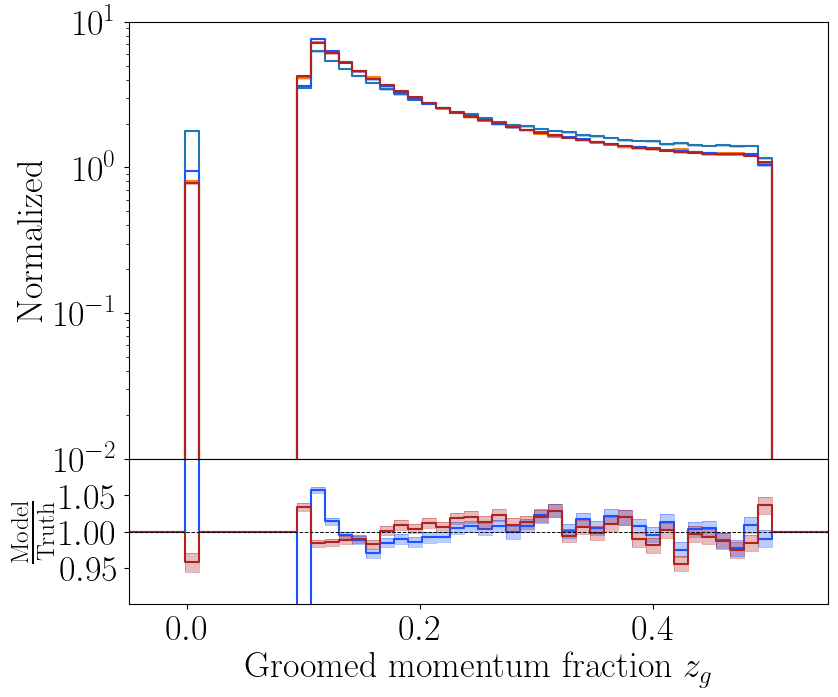

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 3.1622776601683795
Weights for Unc. of unfolds 3.1622776601683795


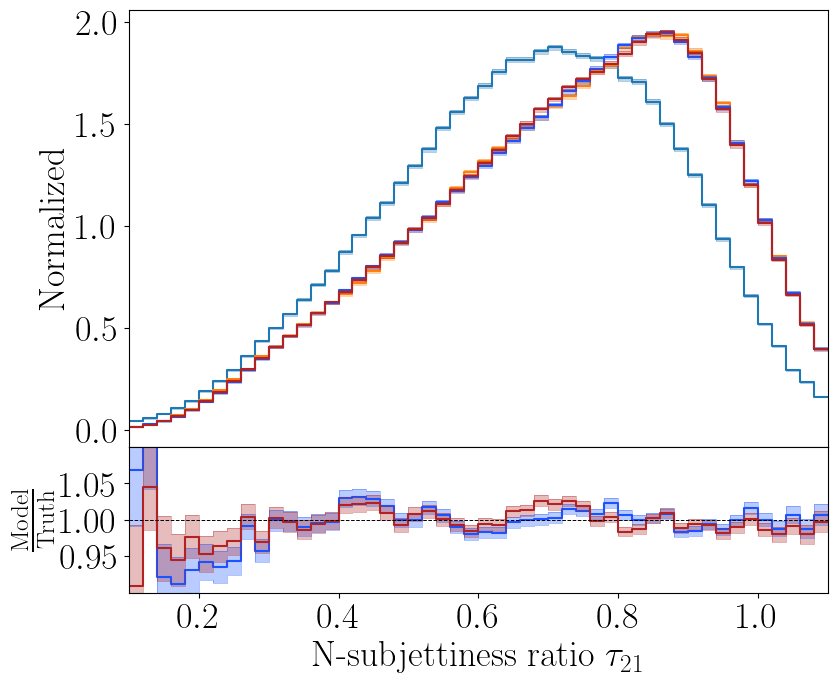

In [827]:
comparison_CFM = comparison_all[0]
comparison_INN = comparison_all[3]

with PdfPages(final_route + "observables-CFM_INN.pdf") as pp:
    for observable_CFM, observable_INN in zip(comparison_CFM, comparison_INN):

        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = CFM_COLOR
        line_CFM.label = "CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "cINN"
        
        # SB
        line_SB = observable_CFM["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_INN.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN],
            bins=bins_CFM,
            n_unfoldings=n_unfoldings,
            observable=obs_CFM,
            bayesian=False,
            show_ratios=True,
            ylim=ylim,
            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label else "lower center" if "momentum" in obs_INN.tex_label else "upper left" if "subjettines" in obs_INN.tex_label else "best")},
        )

## Pythia Observables Plots (BAYESIAN MODELS)

In [828]:
route_CFM = "plots/CFM/20231213_174446_update-long-bay"
route_P_DIDI = "plots/DiDi_paired/20231213_174523_update-long-bay"
route_UP_DIDI = "plots/DiDi_unpaired/20231213_174540_update-long-bay"
route_INN = "plots/RQS_cINN/20231213_174414_update-long-bay"

routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_all = []
for route in routes:
    with open(route + "/observables_comparison.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/final/"

10 UNFOLDINGS


Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


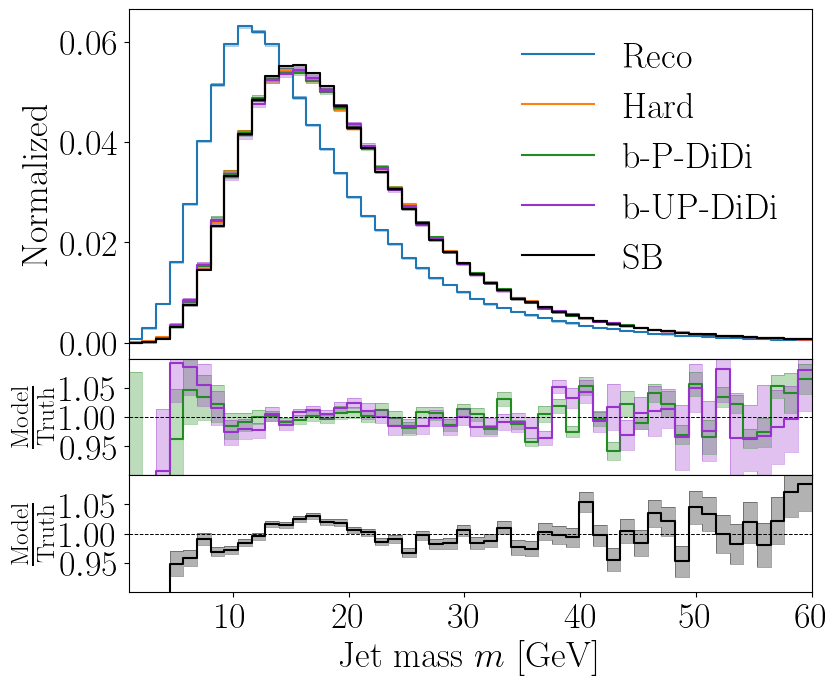

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


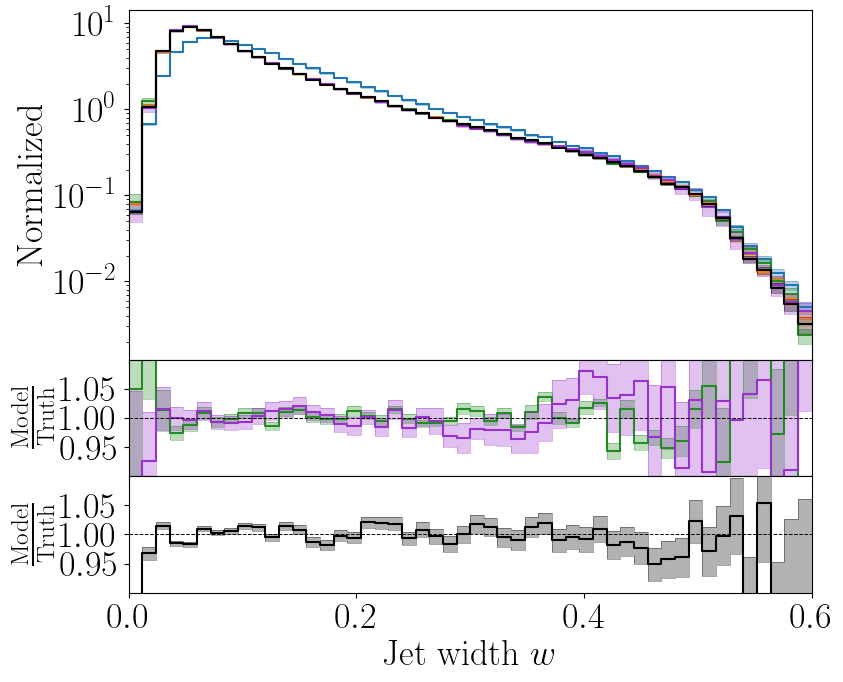

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


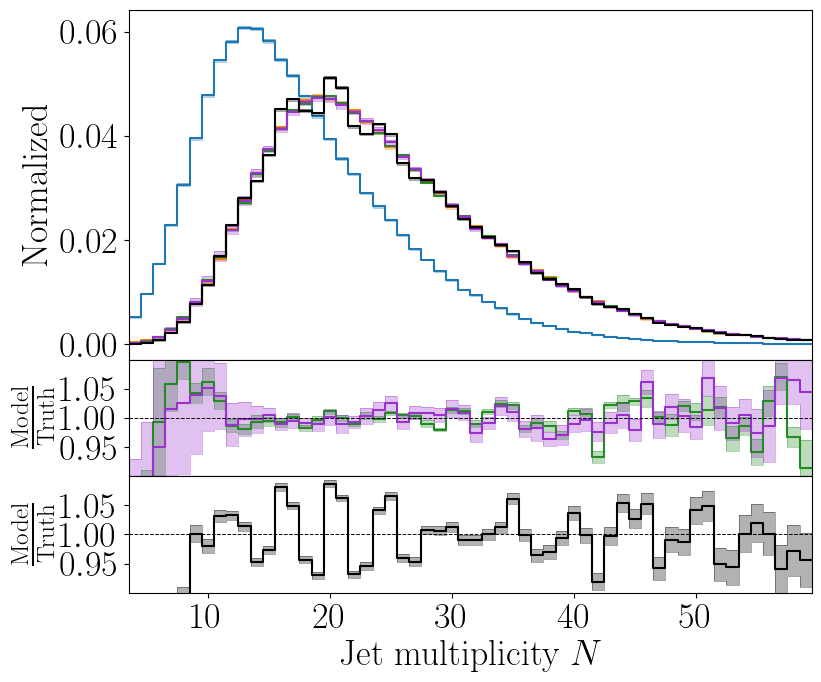

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


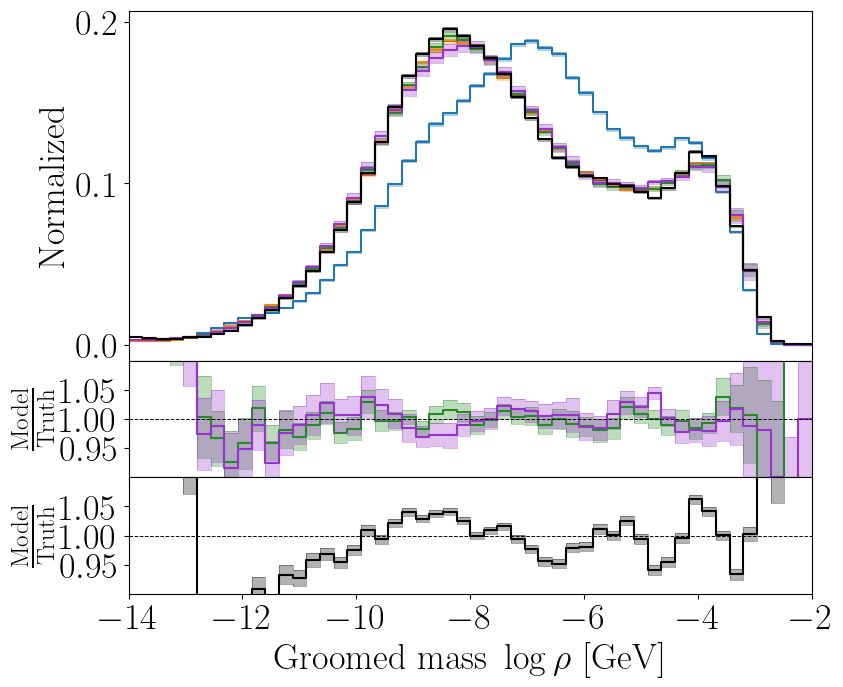

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


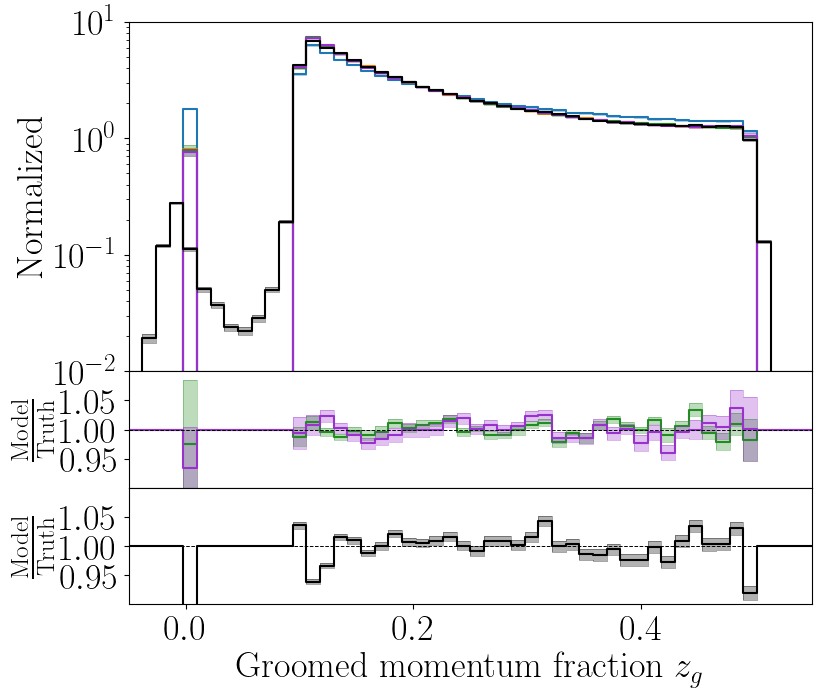

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


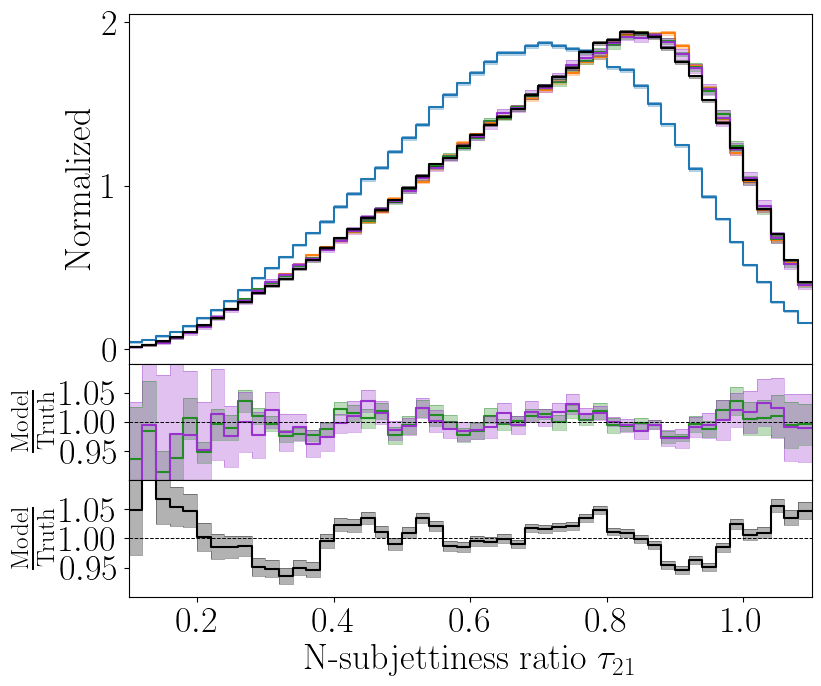

In [829]:
comparison_P_DIDI = comparison_all[1]
comparison_UP_DIDI = comparison_all[2]

with PdfPages(final_route + "observables-SB_DiDi-bay-second_panel.pdf") as pp:
    for observable_P_DIDI, observable_UP_DIDI in zip(comparison_P_DIDI, comparison_UP_DIDI):

        
        # Reco
        line_reco = observable_P_DIDI["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_P_DIDI["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDi paired
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "b-P-DiDi"
        
        # DiDi unpaired
        obs_UP_DIDI = observable_UP_DIDI["obs"]
        bins_UP_DIDI = observable_UP_DIDI["bins"]
        line_UP_DIDI = observable_UP_DIDI["lines"][3]
        line_UP_DIDI.color = UP_DIDI_COLOR
        line_UP_DIDI.label = "b-UP-DiDi"
        
        # SB
        line_SB = observable_P_DIDI["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_P_DIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_P_DIDI, line_UP_DIDI, line_SB],
            n_unfoldings=n_unfoldings,
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            bayesian=True,
            show_ratios=True,
            ylim=ylim,
            plot_SB_on_second_panel=True,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


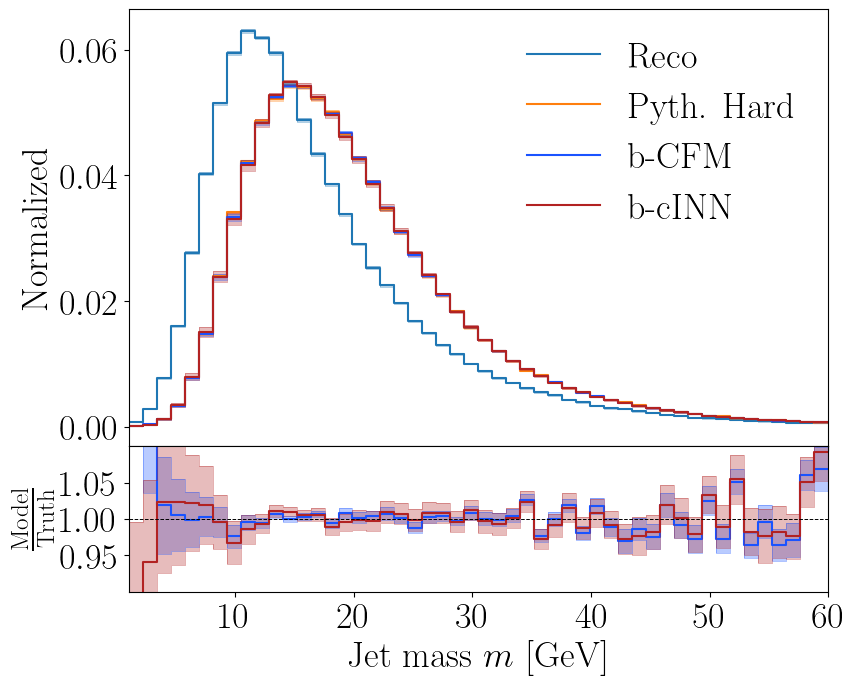

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


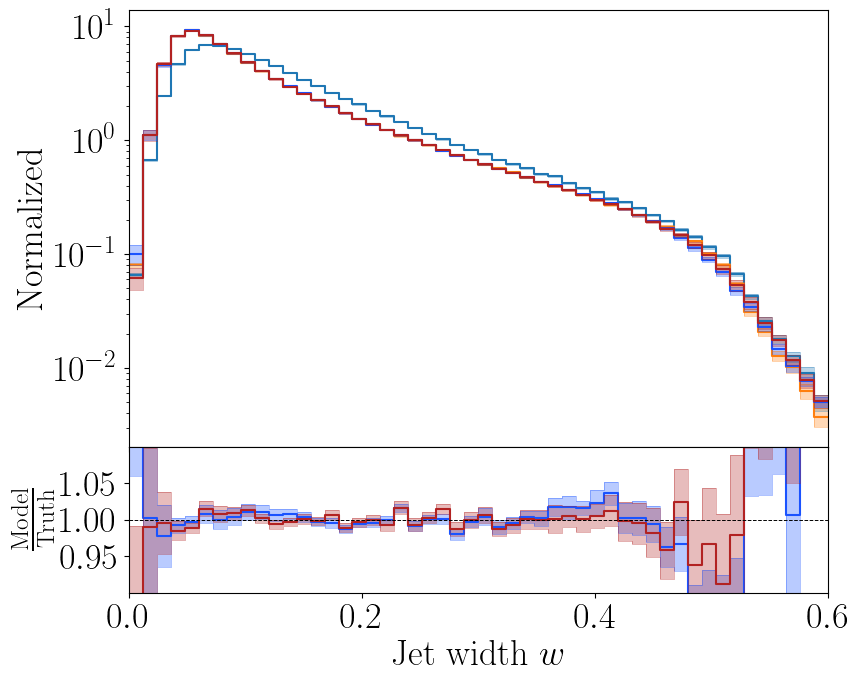

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


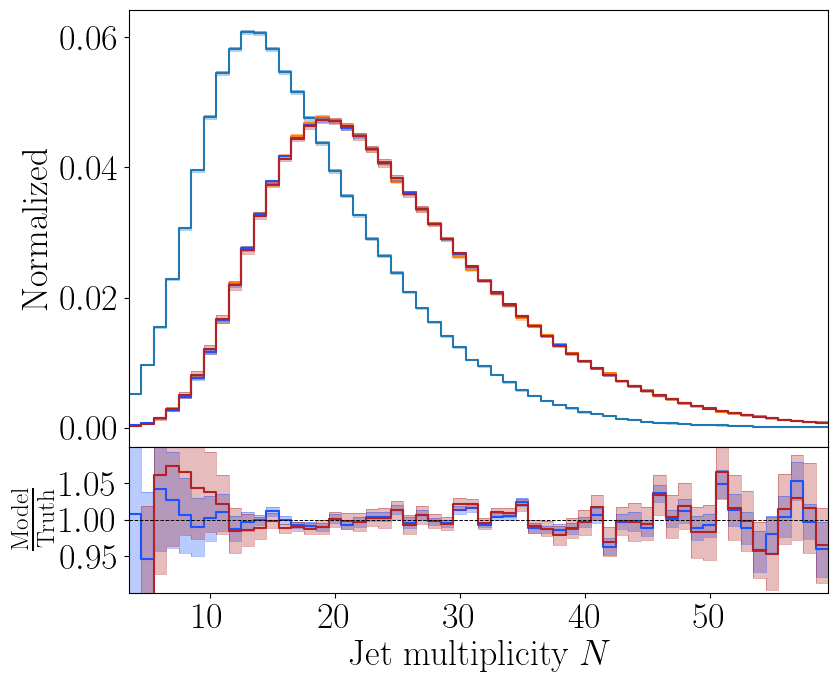

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


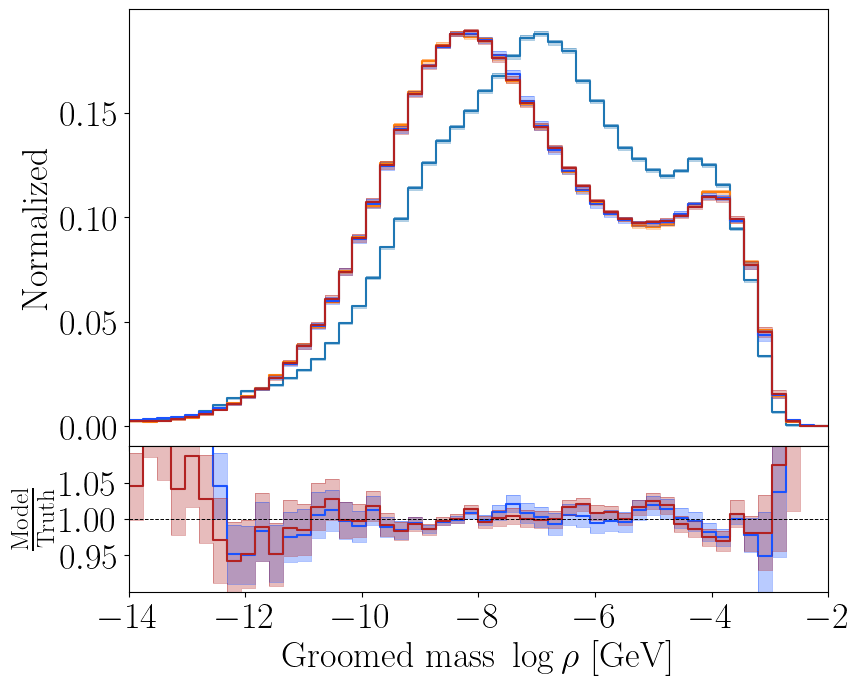

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


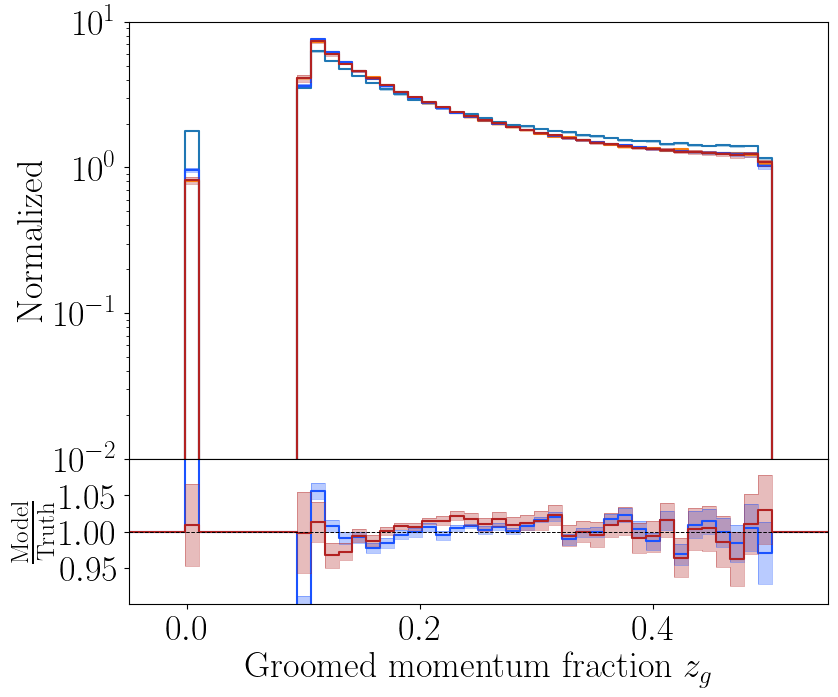

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


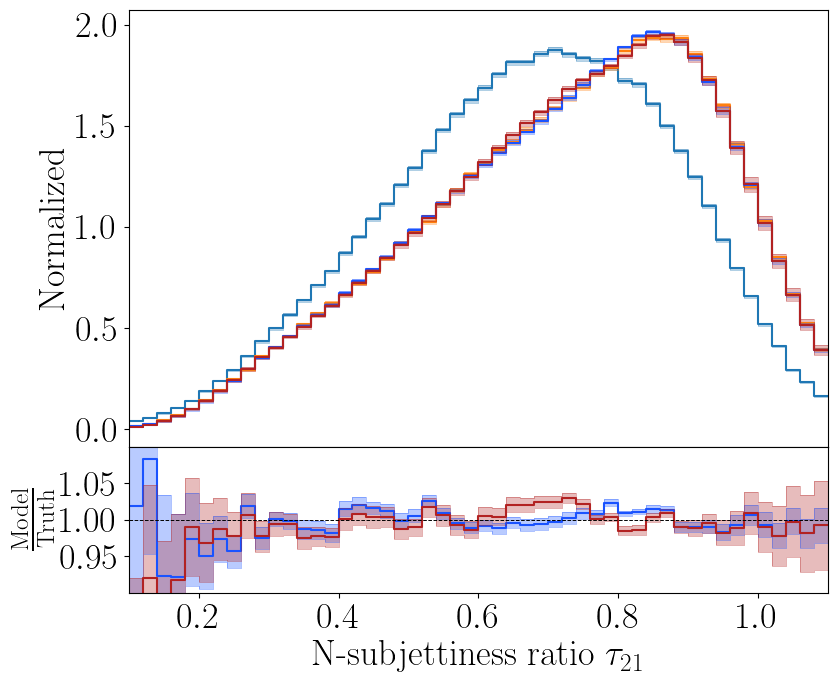

In [830]:
comparison_CFM = comparison_all[0]
comparison_INN = comparison_all[3]

with PdfPages(final_route + "observables-CFM_INN-bay.pdf") as pp:
    for observable_CFM, observable_INN in zip(comparison_CFM, comparison_INN):

        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Pyth. Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = CFM_COLOR
        line_CFM.label = "b-CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "b-cINN"
        
        # SB
        line_SB = observable_CFM["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_INN.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN],
            n_unfoldings=n_unfoldings,
            bins=bins_CFM,
            observable=obs_CFM,
            bayesian=True,
            show_ratios=True,
            ylim=ylim,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label else "lower center" if "momentum" in obs_INN.tex_label else "upper left" if "subjettines" in obs_INN.tex_label else "best")},
        )

## Migration2

In [426]:
route_truth = "plots/gt_"
route_SB = "plots/SB_"
route_CFM = "plots/CFM/20231213_174446_update-long-bay/"
route_P_DIDI = "plots/DiDi_paired/20231213_174523_update-long-bay/"
route_UP_DIDI = "plots/DiDi_unpaired/20231213_174540_update-long-bay/"
route_INN = "plots/RQS_cINN/20231213_174414_update-long-bay/"

routes = [route_truth, route_SB, route_P_DIDI, route_UP_DIDI, route_CFM, route_INN]
migrations_all = []
for route in routes:
    with open(route + "migration2.pkl", "rb") as f:
        migrations_all.append(pickle.load(f))

final_route = "plots/final/migration/"

In [428]:
gt = False
reduce_titles = False
for i, prefix_fname, axis_label in zip(range(len(routes)), 
                                       ["gt", "SB", "P_DiDi", "UP_DiDi", "CFM", "INN"],
                                       ["Hard", "SB", "P-DiDi", "UP-DiDi", "CFM", "cINN"]):
    if i==0: gt = True
    #final_route = final_route + "title_only_on_gt/"
    with PdfPages(final_route + f"{prefix_fname}_migration2.pdf") as pp:
        for k, obs in enumerate(migrations_all[i]):
            h = obs["h"]
            bins = obs["bins"]
            ranges = obs["ranges"]
            obs = obs["obs"]
            if k == 0:
                obs.tex_label = "m"
            elif k == 1:
                obs.tex_label = "\omega"
            elif k == 2:
                obs.tex_label = "N"
            elif k == 3:
                obs.tex_label = "\log{\\rho}"
            elif k == 4:
                obs.tex_label = "z_{g}"
            elif k == 5:
                obs.tex_label = "\\tau_{21}"

            cmap = plt.get_cmap('viridis')
            cmap.set_bad("white")
            fig, ax = plt.subplots(figsize=(6,5))
            up_limit_rect = 0.99
            left_limit_rect = 0.09 if not reduce_titles else 0.05
            if reduce_titles:
                if gt:
                    unit = "" if obs.unit is None else f" [{obs.unit}]"
                    fig.suptitle(f"${{{obs.tex_label}}}${unit}")
                    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(left_limit_rect,0.07,0.999, up_limit_rect))
                else:
                    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(left_limit_rect,0.07,0.999, up_limit_rect))
            else:
                unit = "" if obs.unit is None else f" [{obs.unit}]"
                fig.suptitle(f"${{{obs.tex_label}}}${unit}")
                fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(left_limit_rect,0.08,0.95, up_limit_rect))
            
            #else:
            #    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.075,0.07,0.999,0.99))
            
            im = ax.pcolormesh(bins, bins, h, cmap=cmap, rasterized=True, vmin=ranges[0], vmax=ranges[1])
            #fig.colorbar(im, format=tkr.FormatStrFormatter('%.2f'))

            
            ax.set_xlim(bins[0], bins[-1])
            ax.set_ylim(bins[0], bins[-1])
            ax.set_xlabel("Reco")
            if not reduce_titles or "Jet mass" in obs.tex_label:
                ax.set_ylabel(f"{axis_label}")
            fig.savefig(pp, format= "pdf")
            #fig.savefig(pp, format= "pdf", bbox_inches="tight")
            plt.close()

## Herwig observables plots (BAYESIAN MODELS)

In [831]:
"""
Code to undo the standardization from Berkeley
"""

"""
SB_Herwig_route = "plots/final/SB_Herwig_data/"
SB_Herwig_hard = np.load(SB_Herwig_route + "clean_Herwig_normalized.npy")
SB_Herwig_reco = np.load(SB_Herwig_route + "corrupt_Herwig_normalized.npy")
SB_Herwig_unfold = np.load(SB_Herwig_route + "recon_Herwig_normalized.npy")

gen_norms = {"mean": [20.64276066995817, 0.12282064590728539, 24.68607375, -7.325354631185325, 0.23319347497846407, 0.7331114605418658], "std": [10.472230069670083, 0.09493600400810571, 9.997137105706395, 2.372440650018864, 0.11603723787479486, 0.21222133560694625], "min": [-0.00014793945592828095, 0.0, 1.0, -37.64071630526339, 0.0, 0.0], "max": [268.2101745605469, 0.6835339725410585, 129.0, 0.0, 0.49999945831260656, 1.5524538890960489]}
sim_norms = {"mean": [17.300824837024415, 0.14098477068797563, 17.578643125, -6.995801509364437, 0.24047311431023666, 0.6728525133042466], "std": [10.322296147955338, 0.09606005939990316, 7.931550148541987, 2.4779018398774064, 0.12024468723415481, 0.2031210395299312], "min": [-6.103515625e-05, 0.0, 1.0, -37.56014241218721, 0.0, 0.0], "max": [268.97637939453125, 0.6643881690767338, 97.0, 0.0, 0.4999993845380562, 1.5568787435542293]}
for i in range(len(SB_Herwig_hard[0, :])):
    SB_Herwig_unfold[..., i] = SB_Herwig_unfold[..., i]*gen_norms["std"][i]+gen_norms["mean"][i]
    SB_Herwig_hard[..., i] = SB_Herwig_hard[..., i]*gen_norms["std"][i]+gen_norms["mean"][i]
    SB_Herwig_reco[..., i] = SB_Herwig_reco[..., i]*sim_norms["std"][i]+sim_norms["mean"][i]
np.save("SB_Herwig_unfold.npy", SB_Herwig_unfold)
np.save("SB_Herwig_hard.npy", SB_Herwig_hard)
np.save("SB_Herwig_reco.npy", SB_Herwig_reco)

#plt.hist(SB_unfold[...,0], bins = 32, density=True, histtype="step")
plt.hist(SB_Pythia_hard[...,0], bins = 512, density=True, histtype="step", color="green", label="Pythia hard")
plt.hist(SB_Pythia_reco[...,0], bins = 512, density=True, histtype="step", color="green", label="Pythia reco", ls = "dashed")
plt.hist(SB_Herwig_hard[...,0]*gen_norms["std"][0]+gen_norms["mean"][0], bins = 512, density=True, histtype="step", color="blue", label = "Herwig hard")
plt.hist(SB_Herwig_reco[...,0]*sim_norms["std"][0]+sim_norms["mean"][0], bins = 512, density=True, histtype="step", color="blue", label = "Herwig reco", ls = "dashed")
plt.hist(SB_Herwig_unfold[...,0]*gen_norms["std"][0]+gen_norms["mean"][0], bins = 512, density=True, histtype="step", color="red", label = "SB", ls = "solid")
plt.legend(loc="best")
plt.xlim(1, 60)
plt.savefig(final_route+"test.pdf")
"""

'\nSB_Herwig_route = "plots/final/SB_Herwig_data/"\nSB_Herwig_hard = np.load(SB_Herwig_route + "clean_Herwig_normalized.npy")\nSB_Herwig_reco = np.load(SB_Herwig_route + "corrupt_Herwig_normalized.npy")\nSB_Herwig_unfold = np.load(SB_Herwig_route + "recon_Herwig_normalized.npy")\n\ngen_norms = {"mean": [20.64276066995817, 0.12282064590728539, 24.68607375, -7.325354631185325, 0.23319347497846407, 0.7331114605418658], "std": [10.472230069670083, 0.09493600400810571, 9.997137105706395, 2.372440650018864, 0.11603723787479486, 0.21222133560694625], "min": [-0.00014793945592828095, 0.0, 1.0, -37.64071630526339, 0.0, 0.0], "max": [268.2101745605469, 0.6835339725410585, 129.0, 0.0, 0.49999945831260656, 1.5524538890960489]}\nsim_norms = {"mean": [17.300824837024415, 0.14098477068797563, 17.578643125, -6.995801509364437, 0.24047311431023666, 0.6728525133042466], "std": [10.322296147955338, 0.09606005939990316, 7.931550148541987, 2.4779018398774064, 0.12024468723415481, 0.2031210395299312], "min"

In [832]:
route_CFM = "plots/CFM/20231213_174446_update-long-bay"
route_P_DIDI = "plots/DiDi_paired/20231213_174523_update-long-bay"
route_UP_DIDI = "plots/DiDi_unpaired/20231213_174540_update-long-bay"
route_INN = "plots/RQS_cINN/20231213_174414_update-long-bay"

routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
analysis_all = []
for route in routes:
    with open(route + "/observables_analysis_wSB.pkl", "rb") as f:
        analysis_all.append(pickle.load(f))

n_unfoldings = int(analysis_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/final/"

10 UNFOLDINGS


Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


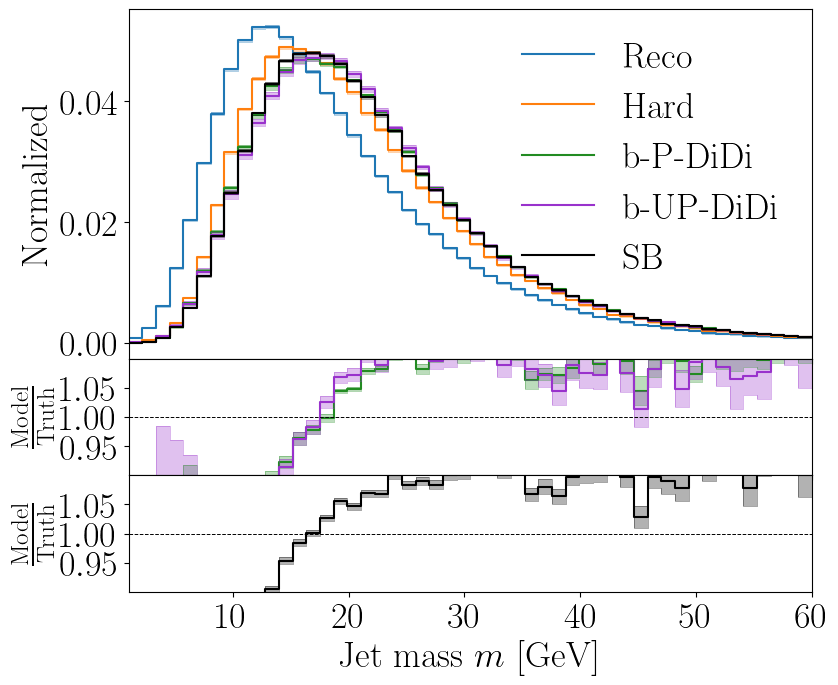

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


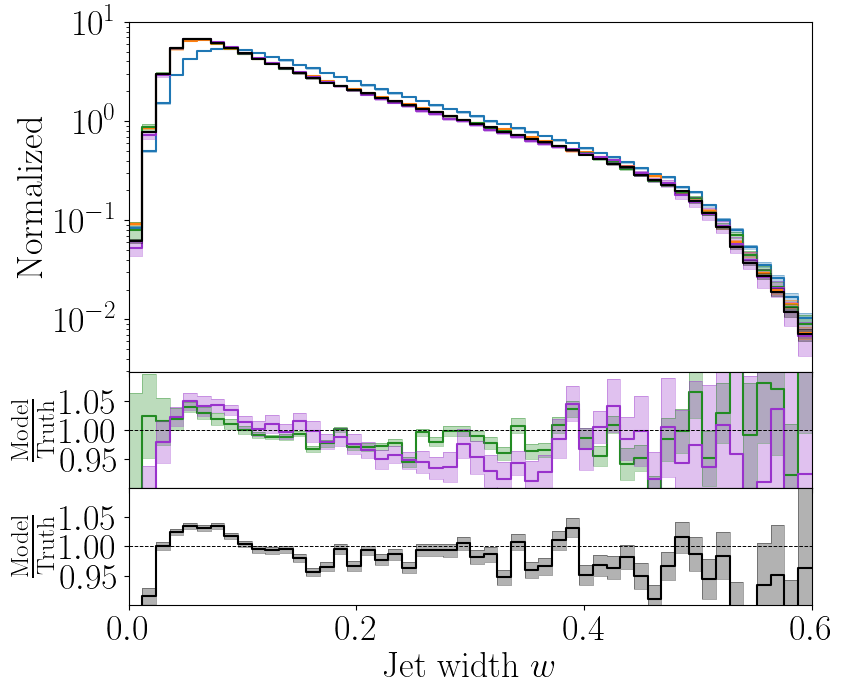

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


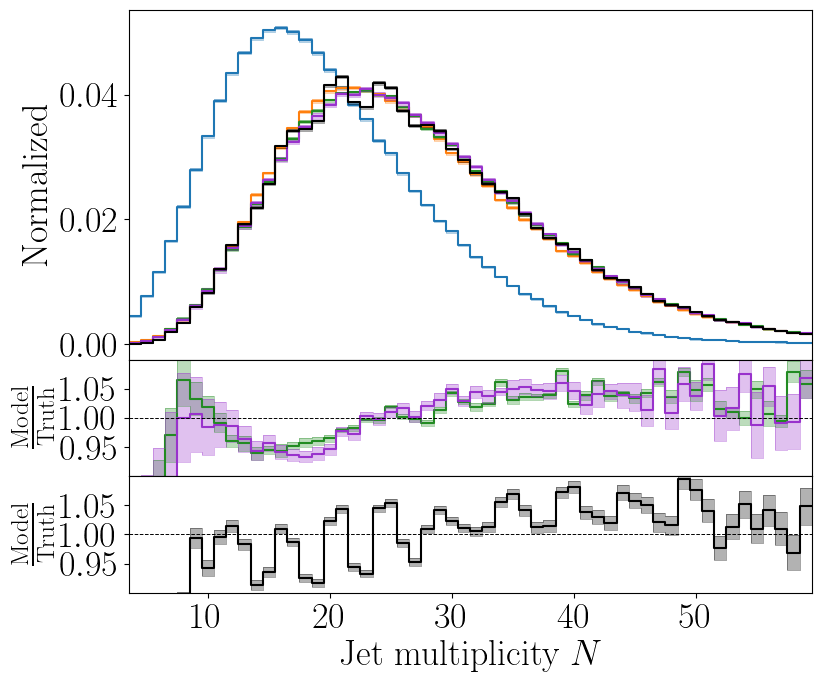

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


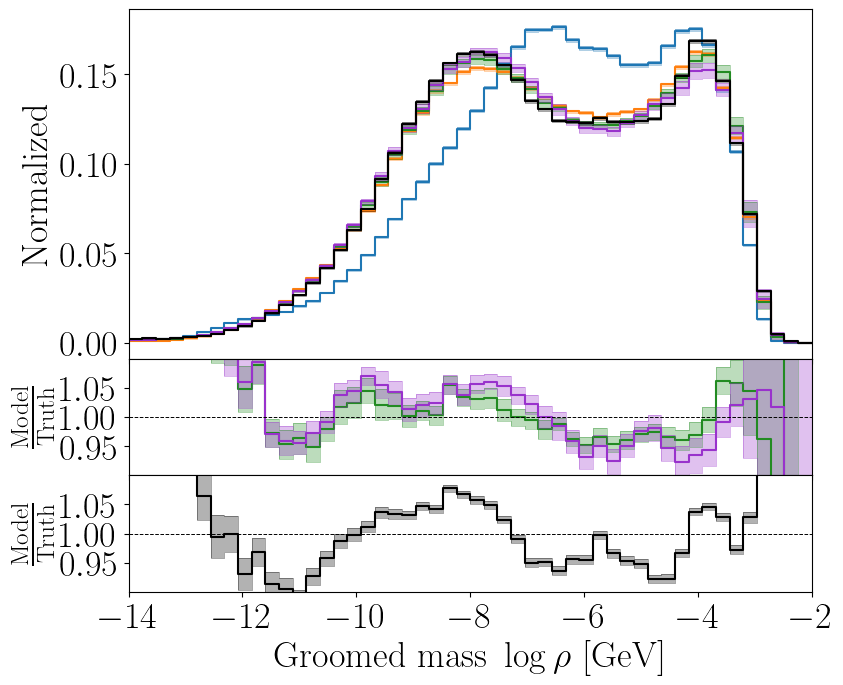

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


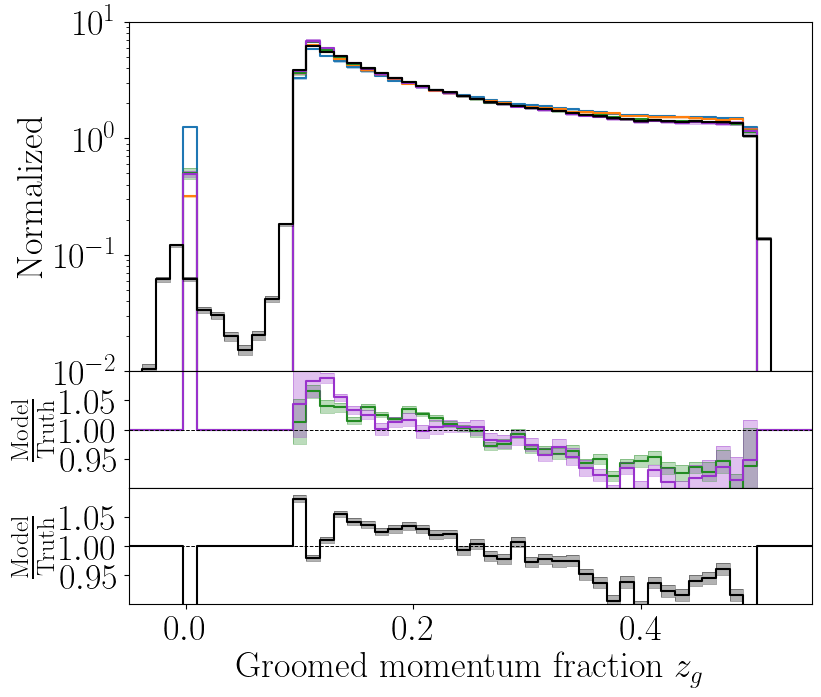

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


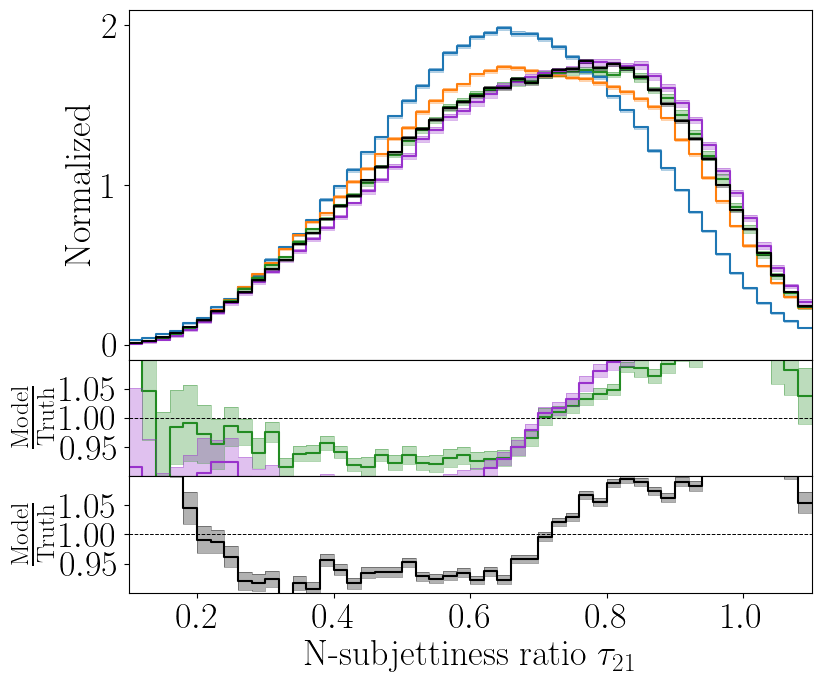

In [833]:
analysis_P_DIDI = analysis_all[1]
analysis_UP_DIDI = analysis_all[2]

with PdfPages(final_route + "analysis/observables-analysis-DiDi_SB-bay.pdf") as pp:
    for observable_P_DIDI, observable_UP_DIDI in zip(analysis_P_DIDI, analysis_UP_DIDI):
        # Reco
        line_reco = observable_P_DIDI["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_P_DIDI["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDi paired
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "b-P-DiDi"
        
        # DiDi unpaired
        obs_UP_DIDI = observable_UP_DIDI["obs"]
        bins_UP_DIDI = observable_UP_DIDI["bins"]
        line_UP_DIDI = observable_UP_DIDI["lines"][3]
        line_UP_DIDI.color = UP_DIDI_COLOR
        line_UP_DIDI.label = "b-UP-DiDi"
        
        # SB
        line_SB = observable_P_DIDI["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_P_DIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_P_DIDI, line_UP_DIDI, line_SB],
            n_unfoldings=n_unfoldings,
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            bayesian=True,
            show_ratios=True,
            ylim=ylim,
            plot_SB_on_second_panel=True,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


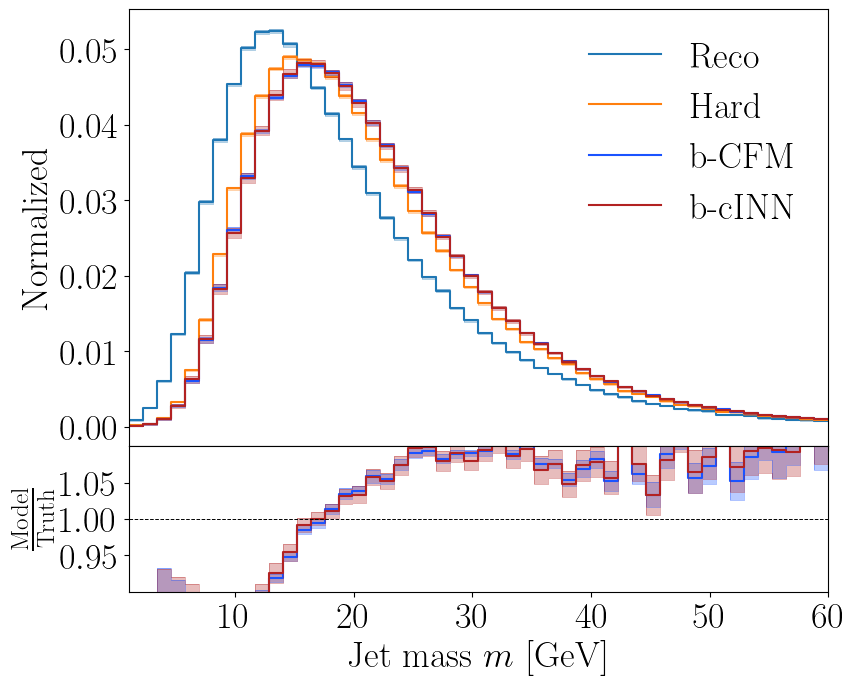

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


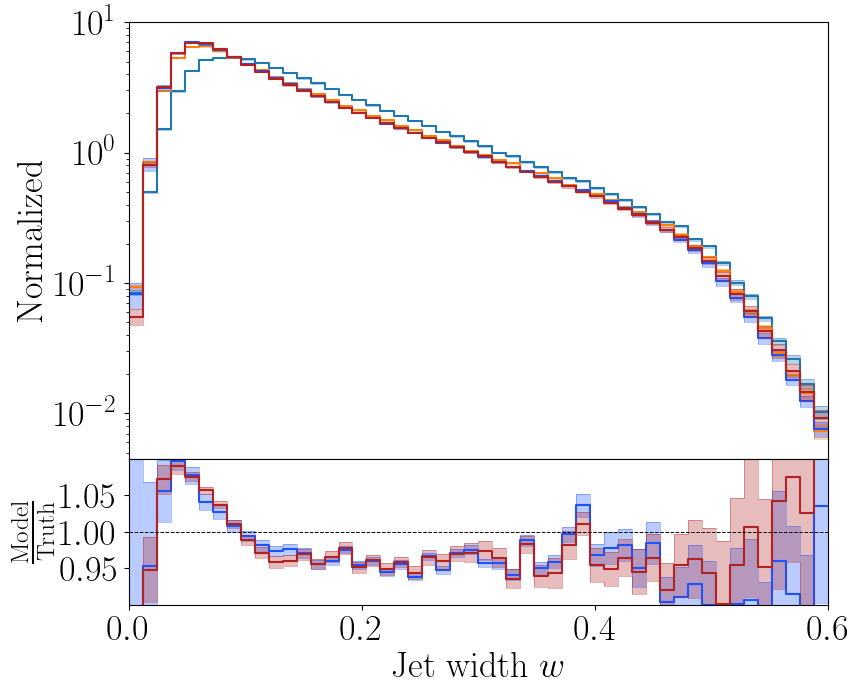

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


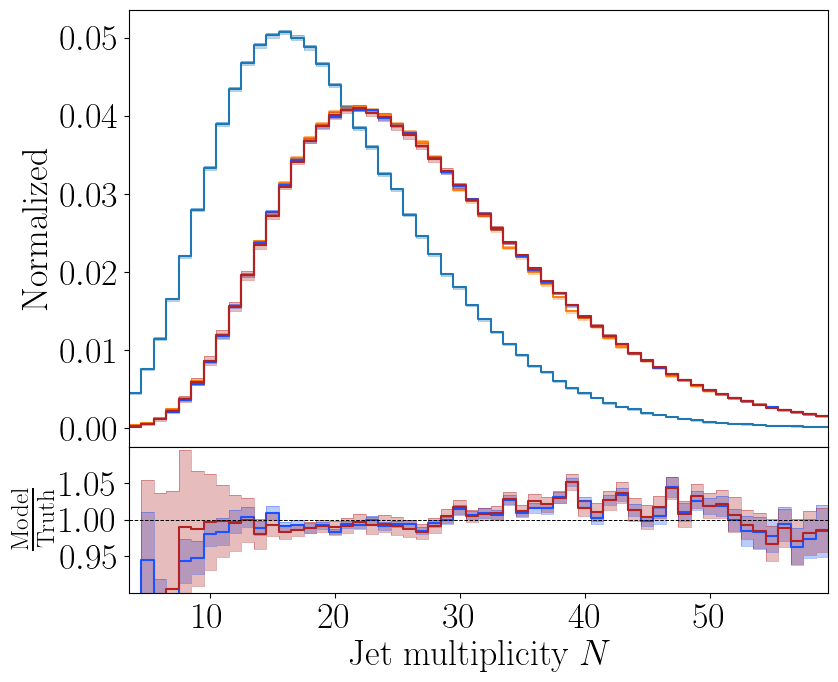

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


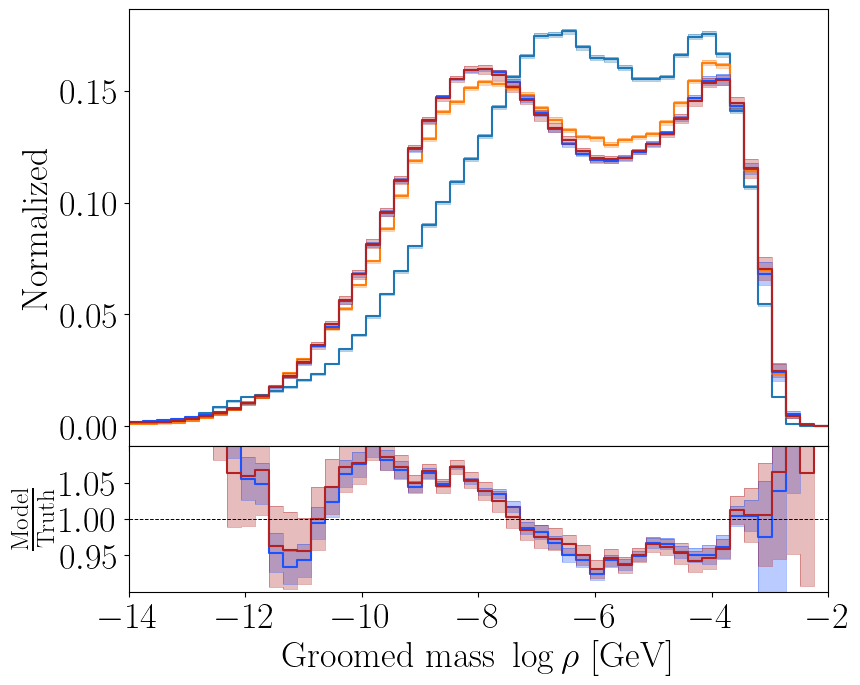

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


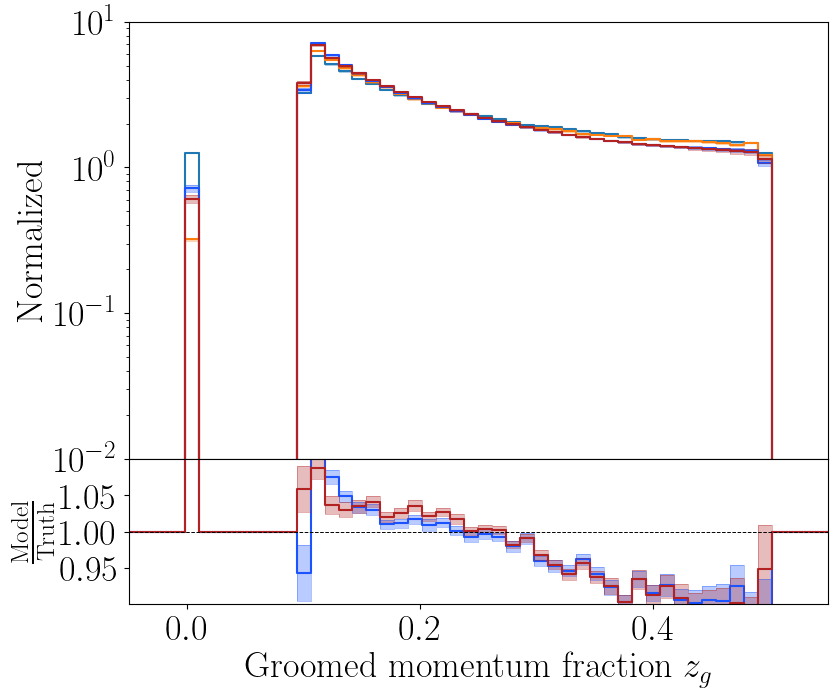

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


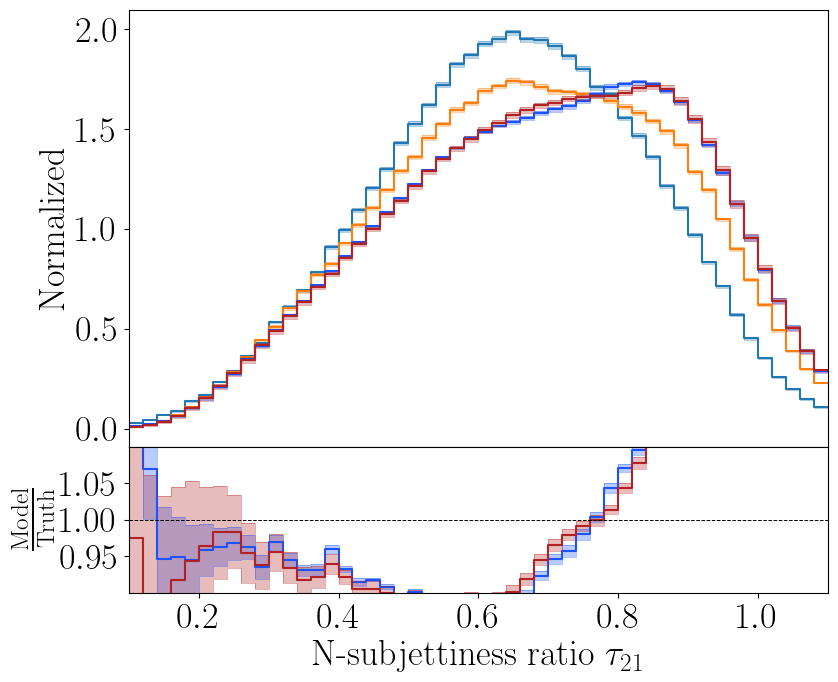

In [834]:
analysis_CFM = analysis_all[0]
analysis_INN = analysis_all[3]

with PdfPages(final_route + "analysis/observables-analysis-CFM_INN-bay.pdf") as pp:
    for observable_CFM, observable_INN in zip(analysis_CFM, analysis_INN):
        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = CFM_COLOR
        line_CFM.label = "b-CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "b-cINN"
        
        # SB
        line_SB = observable_CFM["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_INN.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN],
            n_unfoldings=n_unfoldings,
            bins=bins_CFM,
            observable=obs_CFM,
            bayesian=True,
            show_ratios=True,
            ylim=ylim,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

## Omnifold vs bOmnifold

In [13]:
route_omnifold = "plots/Omnifold/20240127_024641_full_dataset-030epochs"
route_bOmnifold = "plots/Omnifold/20240127_024746_full_dataset-030epochs-bay"

routes = [route_omnifold, route_bOmnifold]

reco_all = []
for route in routes:
    with open(route + "/reco.pkl", "rb") as f:
        reco_all.append(pickle.load(f))

observables_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        observables_all.append(pickle.load(f))

final_route = "plots/final/"

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


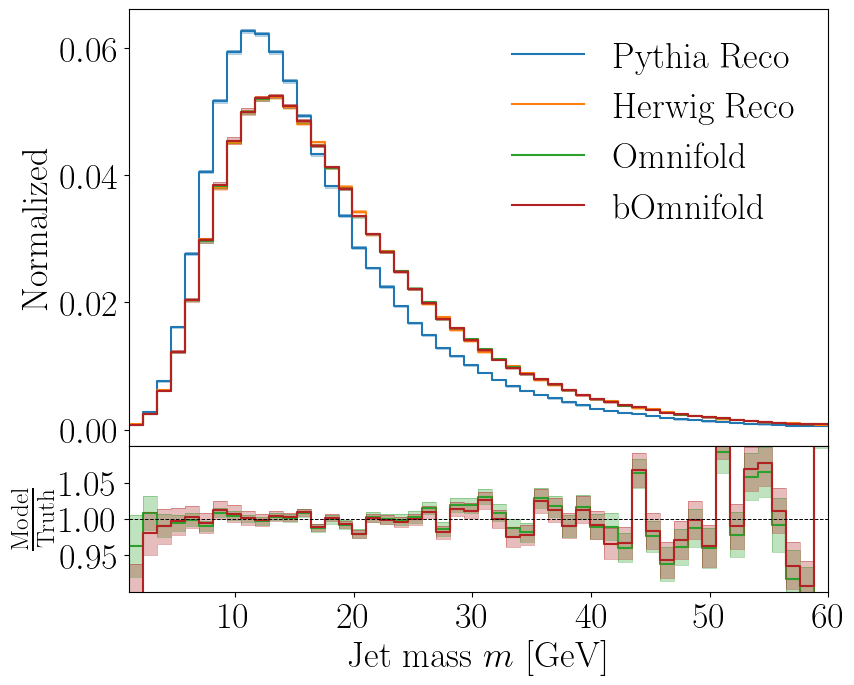

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


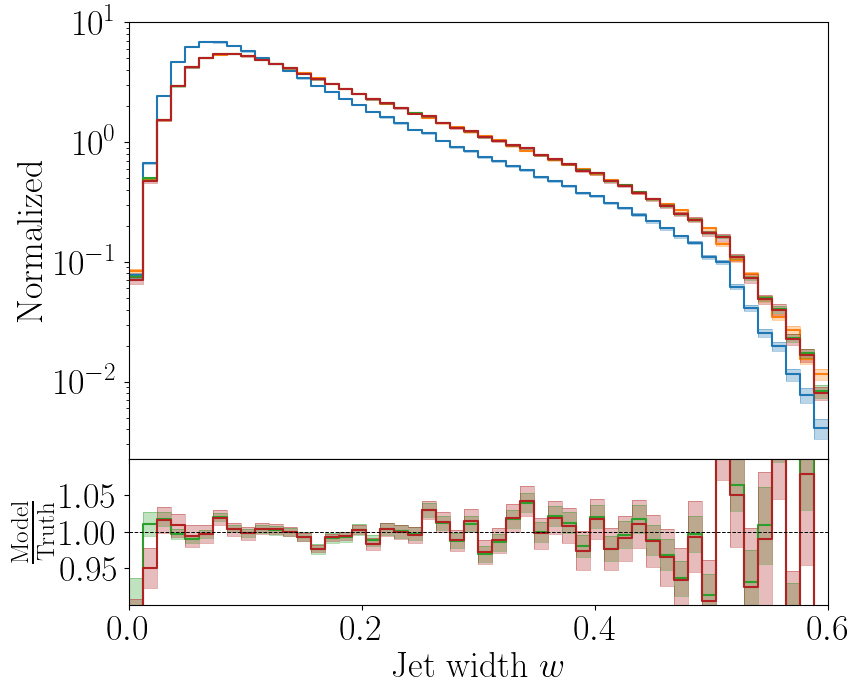

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


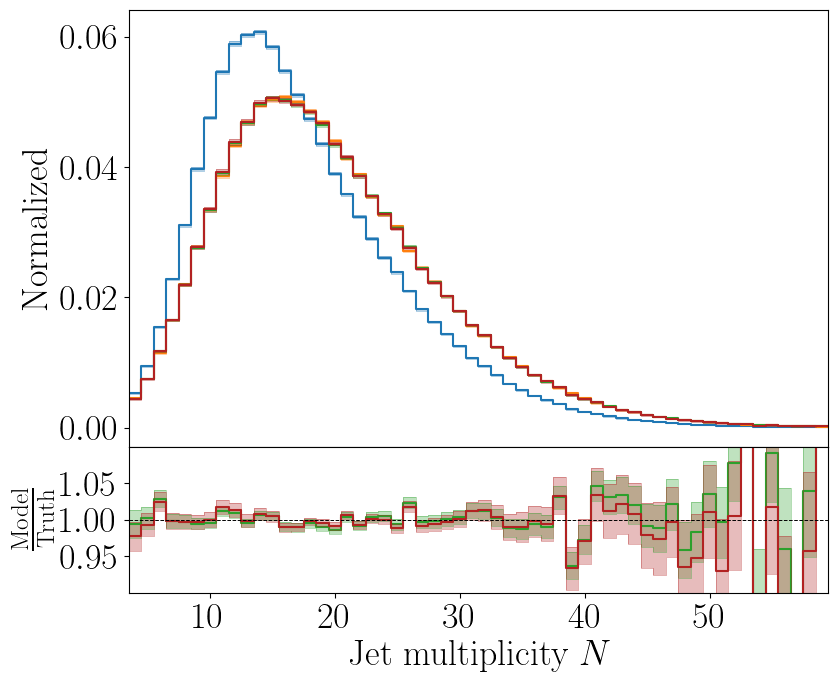

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


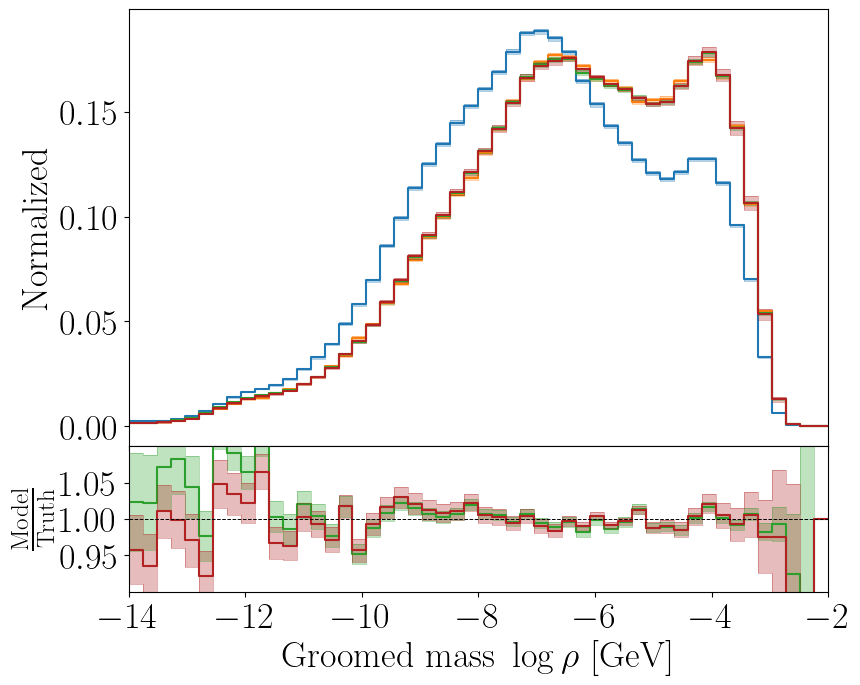

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


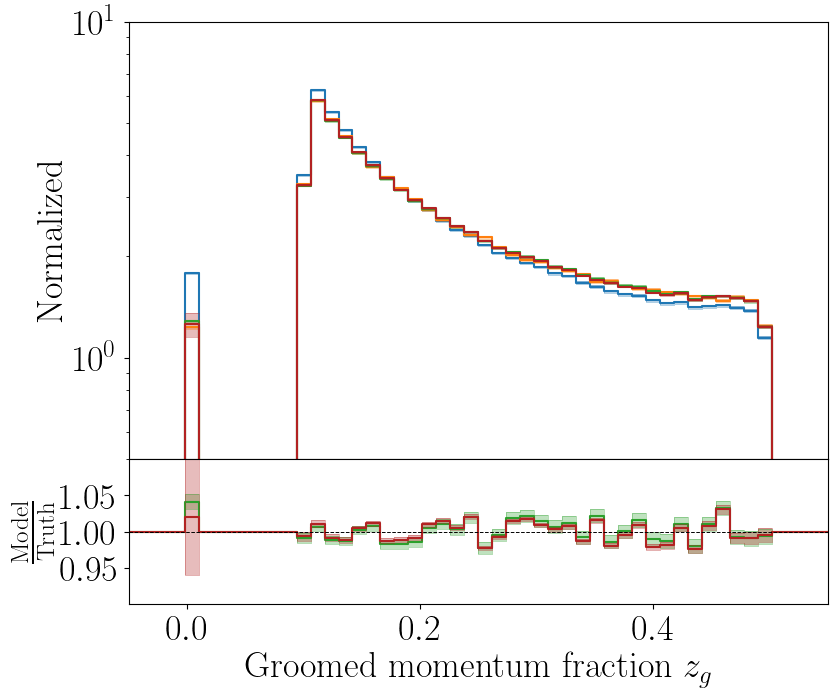

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


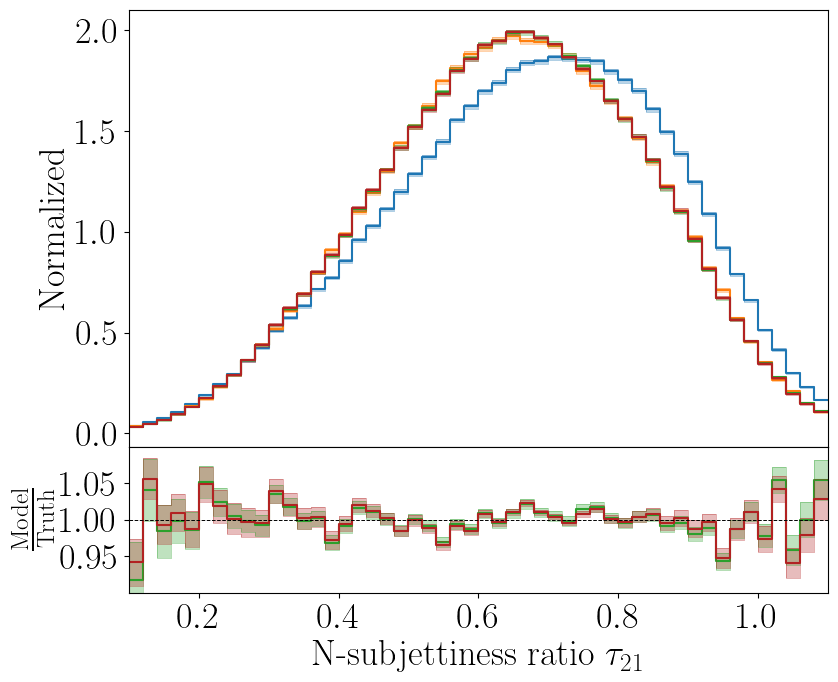

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


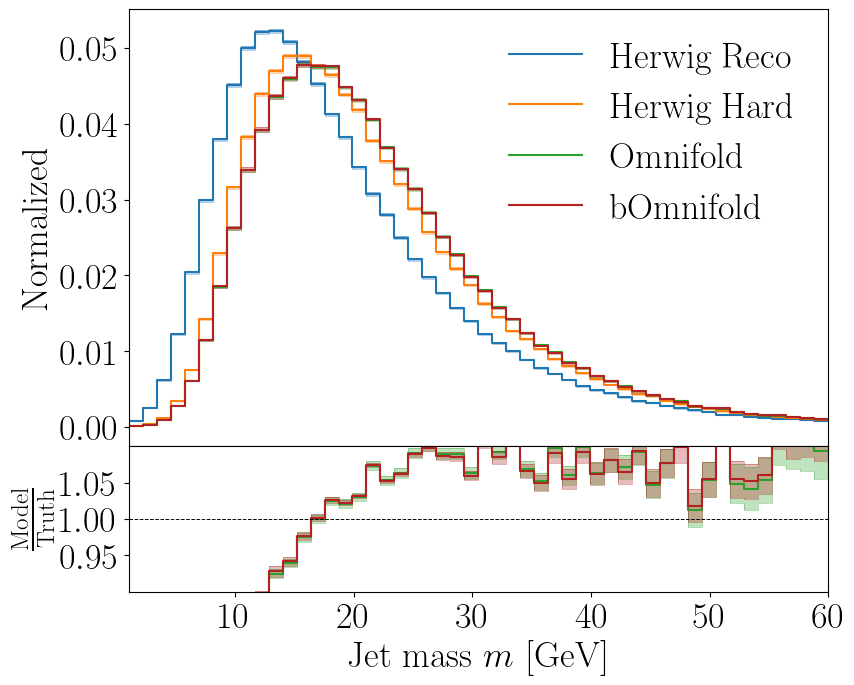

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


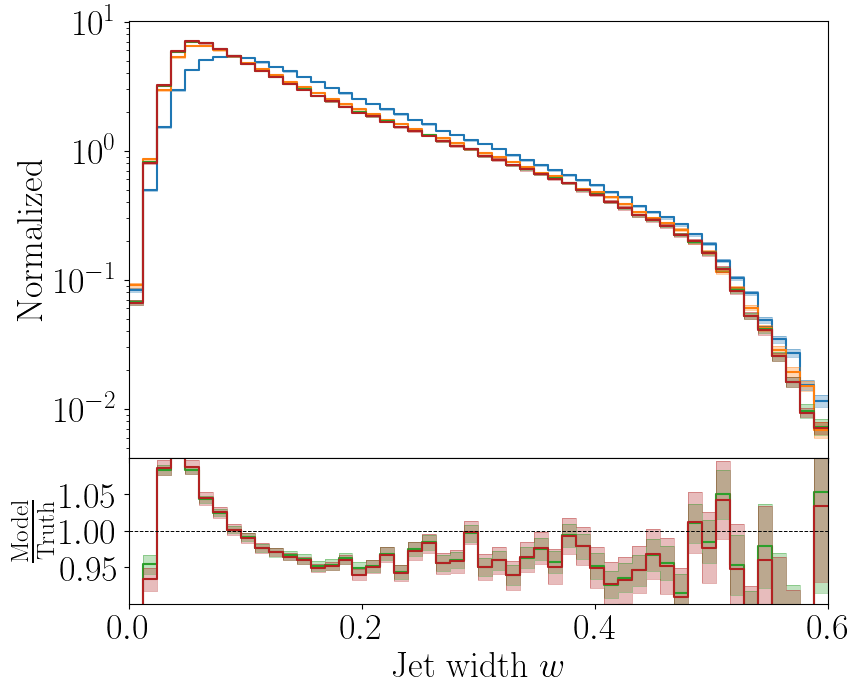

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


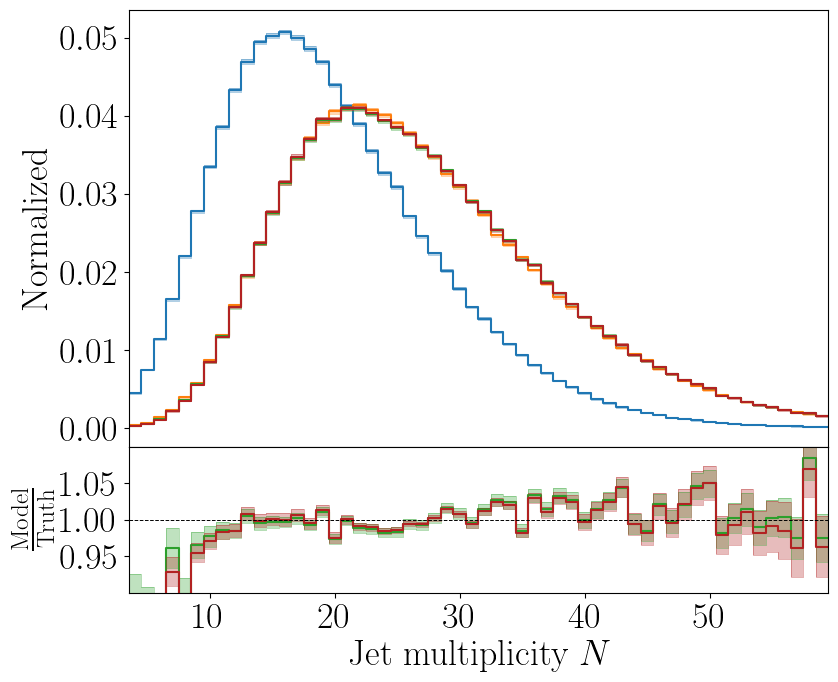

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


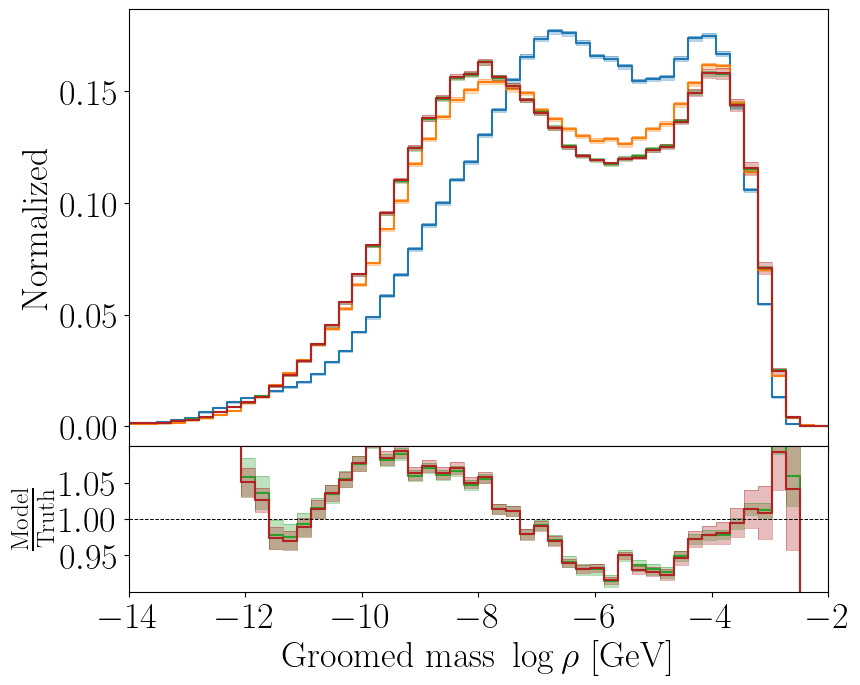

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


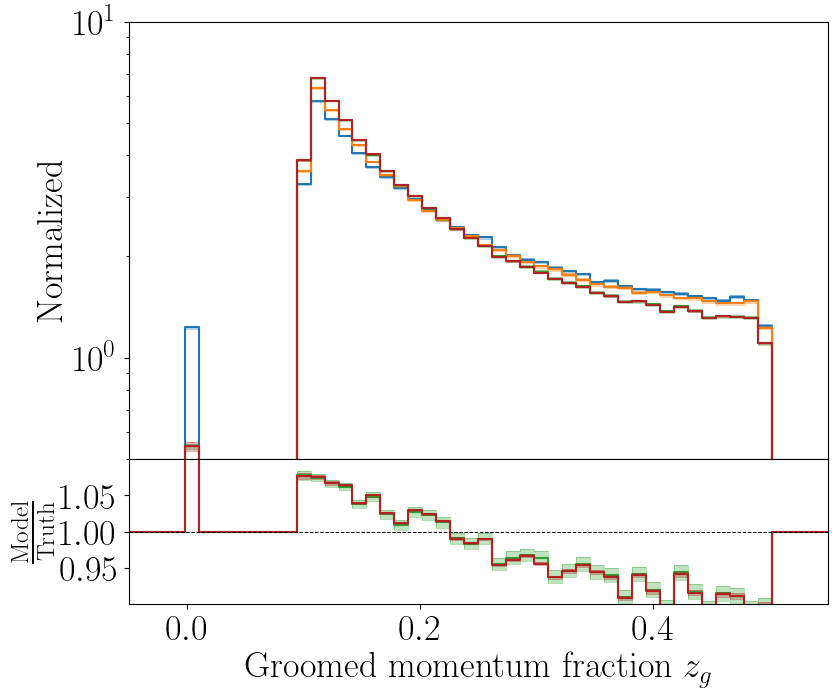

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


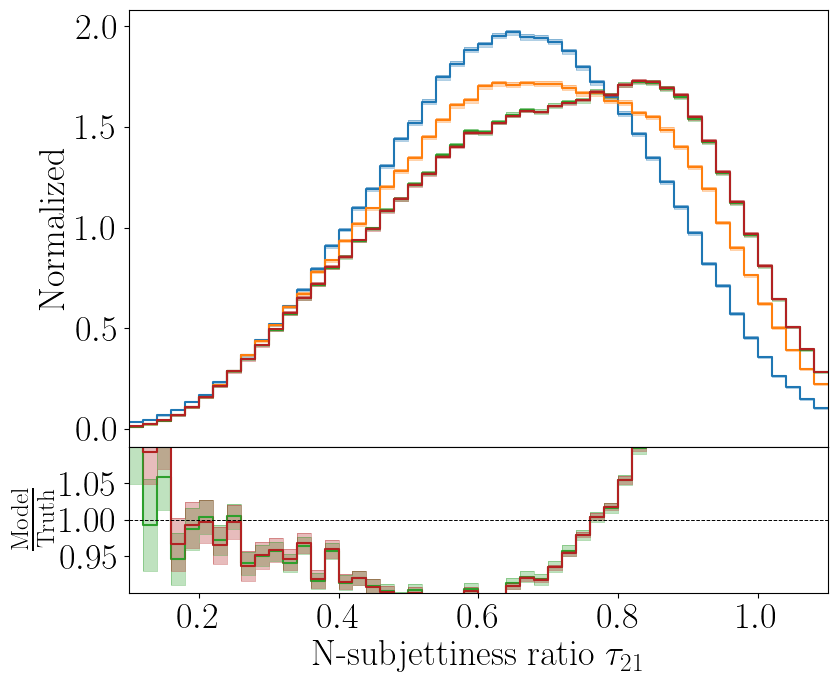

In [14]:
'''
RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "Omnifold/reco.pdf") as pp:
    for reco_omnifold, reco_bOmnifold in zip(reco_all[0], reco_all[1]):
        
        obs = reco_bOmnifold["obs"]
        bins = reco_bOmnifold["bins"]

        # Pythia Reco
        line_Pythia_reco = reco_bOmnifold["lines"][0]
        line_Pythia_reco.color = RECO_COLOR
        line_Pythia_reco.label = "Pythia Reco"

        # Herwig Reco
        line_Herwig_reco = reco_bOmnifold["lines"][1]
        line_Herwig_reco.color = HARD_COLOR
        line_Herwig_reco.label = "Herwig Reco"

        # omnifold reweighted
        line_omnifold = reco_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"

        # bOmnifold reweighted
        line_bOmnifold = reco_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Herwig_reco, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )



'''
OBSERVABLES
'''
with PdfPages(final_route + "Omnifold/observables.pdf") as pp:
    for observables_omnifold, observables_bOmnifold in zip(observables_all[0], observables_all[1]):
        
        obs = observables_bOmnifold["obs"]
        bins = observables_bOmnifold["bins"]

        # Pythia Reco
        line_reco = observables_bOmnifold["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Herwig Reco"

        # Herwig Hard 
        line_hard = observables_bOmnifold["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Herwig Hard"
        
        # omnifold reweighted
        line_omnifold = observables_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"
        
        # bOmnifold reweighted
        line_bOmnifold = observables_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None

        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

In [18]:
route_omnifold = "plots/Omnifold/20240125_011430_half_dataset-500epochs-loader_theirs"
route_bOmnifold = "plots/Omnifold/20240125_120152_half_dataset-500epochs-loader_theirs-bay"

routes = [route_omnifold, route_bOmnifold]

reco_train_all = []
for route in routes:
    with open(route + "/reco_train.pkl", "rb") as f:
        reco_train_all.append(pickle.load(f))

reco_all = []
for route in routes:
    with open(route + "/reco.pkl", "rb") as f:
        reco_all.append(pickle.load(f))

observables_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        observables_all.append(pickle.load(f))

final_route = "plots/final/"

In [19]:
'''
TRAINING SET RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/comparison-reco_train.pdf") as pp:
    for reco_train_omnifold, reco_train_bOmnifold in zip(reco_train_all[0], reco_train_all[1]):
        
        obs = reco_train_bOmnifold["obs"]
        bins = reco_train_bOmnifold["bins"]

        # Pythia Reco
        line_Pythia_reco = reco_train_bOmnifold["lines"][0]
        line_Pythia_reco.color = RECO_COLOR
        line_Pythia_reco.label = "Pythia Reco"

        # Herwig Reco
        line_Herwig_reco = reco_train_bOmnifold["lines"][1]
        line_Herwig_reco.color = HARD_COLOR
        line_Herwig_reco.label = "Herwig Reco"

        # omnifold reweighted
        line_omnifold = reco_train_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"

        # bOmnifold reweighted
        line_bOmnifold = reco_train_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Herwig_reco, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )



'''
RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/comparison-reco.pdf") as pp:
    for reco_omnifold, reco_bOmnifold in zip(reco_all[0], reco_all[1]):
        
        obs = reco_bOmnifold["obs"]
        bins = reco_bOmnifold["bins"]

        # Pythia Reco
        line_Pythia_reco = reco_bOmnifold["lines"][0]
        line_Pythia_reco.color = RECO_COLOR
        line_Pythia_reco.label = "Pythia Reco"

        # Herwig Reco
        line_Herwig_reco = reco_bOmnifold["lines"][1]
        line_Herwig_reco.color = HARD_COLOR
        line_Herwig_reco.label = "Herwig Reco"

        # omnifold reweighted
        line_omnifold = reco_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"

        # bOmnifold reweighted
        line_bOmnifold = reco_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Herwig_reco, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )



'''
OBSERVABLES
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/comparison-observables.pdf") as pp:
    for observables_omnifold, observables_bOmnifold in zip(observables_all[0], observables_all[1]):
        
        obs = observables_bOmnifold["obs"]
        bins = observables_bOmnifold["bins"]

        # Pythia Reco
        line_reco = observables_bOmnifold["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Herwig Reco"

        # Herwig Hard 
        line_hard = observables_bOmnifold["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Herwig Hard"
        
        # omnifold reweighted
        line_omnifold = observables_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"
        
        # bOmnifold reweighted
        line_bOmnifold = observables_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None

        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights fo

### Pythia only

In [20]:
route_omnifold = "output/Omnifold/20240203_175859_onlypythia-long"
route_bOmnifold = "output/Omnifold/20240203_180029_onlypythia-long-bay"

routes = [route_omnifold, route_bOmnifold]

reco_train_all = []
for route in routes:
    with open(route + "/reco_train.pkl", "rb") as f:
        reco_train_all.append(pickle.load(f))

reco_all = []
for route in routes:
    with open(route + "/reco.pkl", "rb") as f:
        reco_all.append(pickle.load(f))

observables_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        observables_all.append(pickle.load(f))

final_route = "plots/final/"

In [25]:
'''
TRAINING SET RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/pythia_only/comparison-reco_train.pdf") as pp:
    for reco_train_omnifold, reco_train_bOmnifold in zip(reco_train_all[0], reco_train_all[1]):
        
        obs = reco_train_bOmnifold["obs"]
        bins = reco_train_bOmnifold["bins"]

        # Pythia Reco 1
        line_Pythia_reco1 = reco_train_bOmnifold["lines"][0]
        line_Pythia_reco1.color = RECO_COLOR

        # Pythia Reco 2
        line_Pythia_reco2 = reco_train_bOmnifold["lines"][1]
        line_Pythia_reco2.color = HARD_COLOR


        # omnifold reweighted
        line_omnifold = reco_train_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR

        # bOmnifold reweighted
        line_bOmnifold = reco_train_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco1, line_Pythia_reco2, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )



'''
RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/pythia_only/comparison-reco.pdf") as pp:
    for reco_omnifold, reco_bOmnifold in zip(reco_all[0], reco_all[1]):
        
        obs = reco_bOmnifold["obs"]
        bins = reco_bOmnifold["bins"]

        # Pythia Reco 1
        line_Pythia_reco1 = reco_bOmnifold["lines"][0]
        line_Pythia_reco1.color = RECO_COLOR

        # Pythia Reco 2
        line_Pythia_reco2 = reco_bOmnifold["lines"][1]
        line_Pythia_reco2.color = HARD_COLOR


        # omnifold reweighted
        line_omnifold = reco_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR

        # bOmnifold reweighted
        line_bOmnifold = reco_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco1, line_Pythia_reco2, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )



'''
OBSERVABLES
'''
with PdfPages(final_route + "Omnifold/bOmnifold_vs_Omnifold/pythia_only/comparison-observables.pdf") as pp:
    for observables_omnifold, observables_bOmnifold in zip(observables_all[0], observables_all[1]):
        
        obs = observables_bOmnifold["obs"]
        bins = observables_bOmnifold["bins"]

        # Pythia Reco 2
        line_Pythia_reco2 = observables_bOmnifold["lines"][0]
        line_Pythia_reco2.color = RECO_COLOR

        # Pythia Hard 2
        line_Pythia_hard2 = observables_bOmnifold["lines"][1]
        line_Pythia_hard2.color = HARD_COLOR
        
        # omnifold reweighted
        line_omnifold = observables_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        
        # bOmnifold reweighted
        line_bOmnifold = observables_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None

        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco2, line_Pythia_hard2, line_omnifold, line_bOmnifold],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=1,
            show_ratios=True,
            ylim=ylim,

            show=False,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights fo

## Plot dataset

In [781]:
route = "plots/CFM/20231213_174446_update-long-bay"
with open(route + "/observables_comparison.pkl", "rb") as f:
    Pythia = pickle.load(f)
with open(route + "/observables_analysis.pkl", "rb") as f:
    Herwig = pickle.load(f)
final_route = "plots/final/"

In [782]:
Pythia_hard = []
Pythia_reco = []
for k in range(len(Pythia)):
    Pythia_reco.append(Pythia[k]["lines"][0])
    Pythia_hard.append(Pythia[k]["lines"][1])

Herwig_hard = []
Herwig_reco = []
for k in range(len(Pythia)):
    Herwig_reco.append(Herwig[k]["lines"][0])
    Herwig_hard.append(Herwig[k]["lines"][1])

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


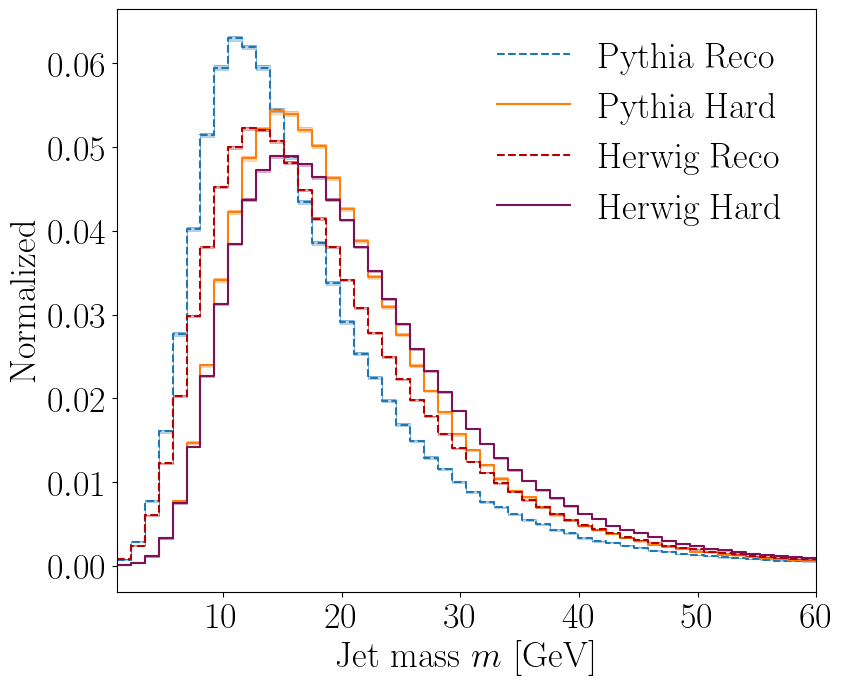

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


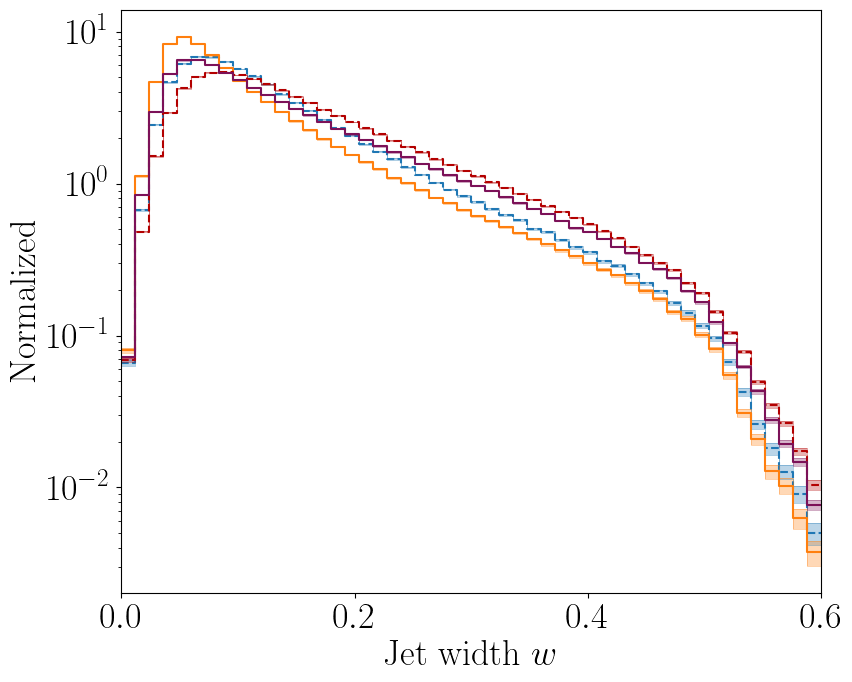

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


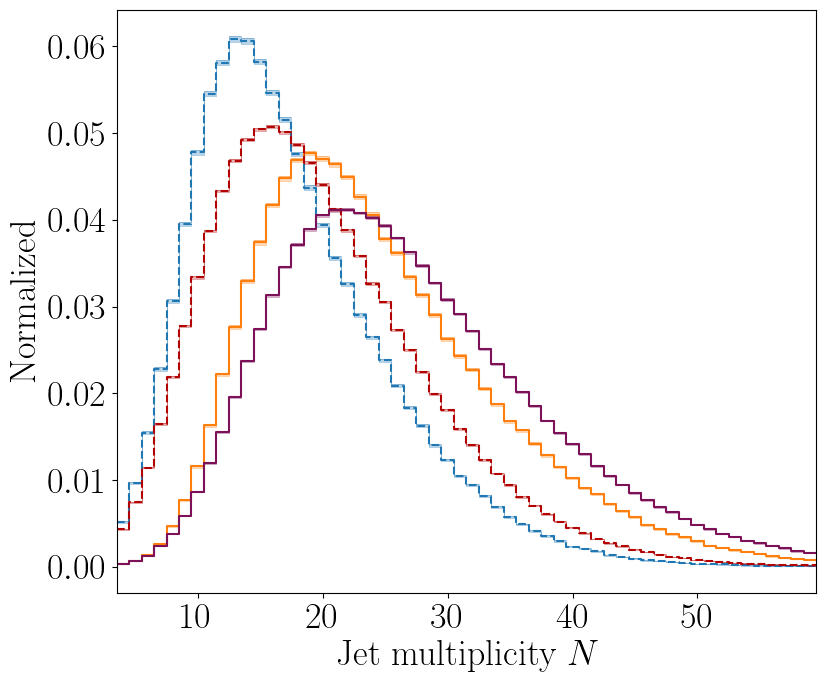

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


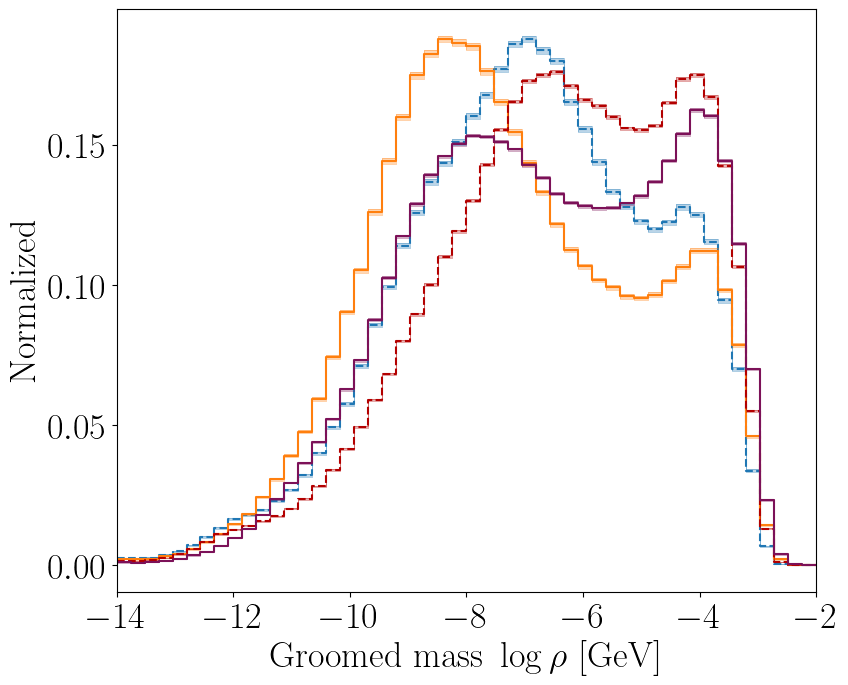

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


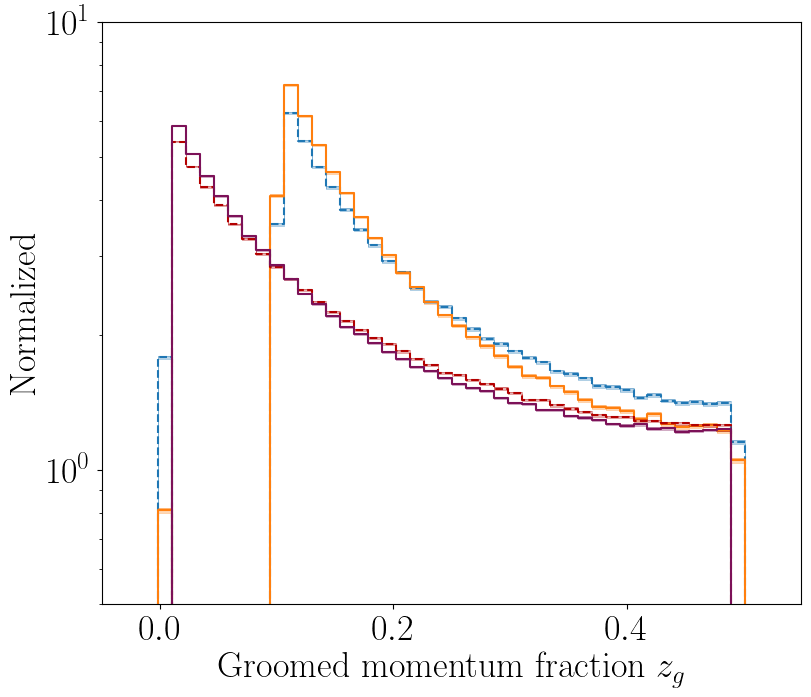

Pythia Reco
Weights for Unc. of unfolds 1
Pythia Hard
Weights for Unc. of unfolds 1
Herwig Reco
Weights for Unc. of unfolds 1
Herwig Hard
Weights for Unc. of unfolds 1


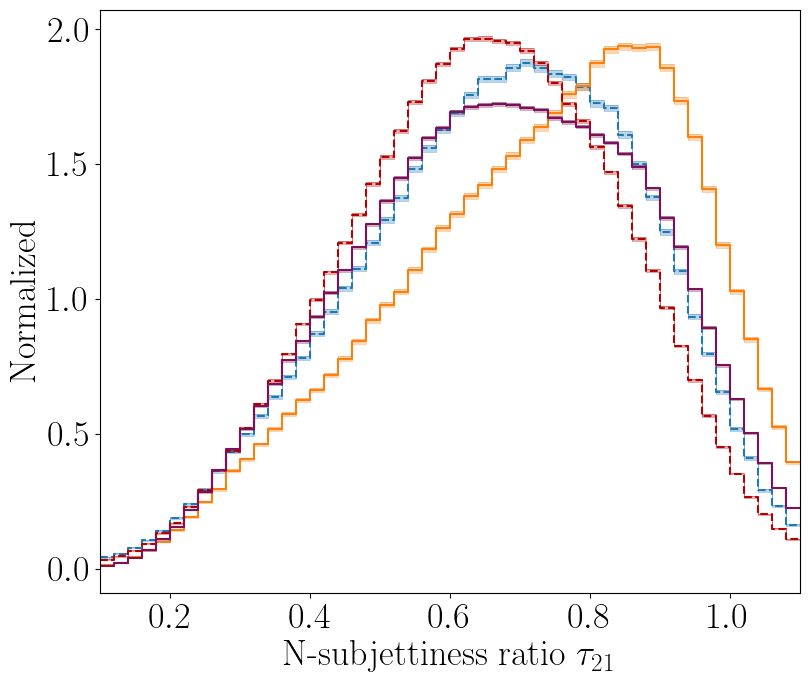

In [785]:
with PdfPages(final_route + "dataset.pdf") as pp:
    for observables_Pythia, observables_Herwig in zip(Pythia, Herwig):
        
        obs = observables_Pythia["obs"]
        bins = observables_Pythia["bins"]

        # Pythia Reco
        line_Pythia_reco = observables_Pythia["lines"][0]
        line_Pythia_reco.color = RECO_COLOR
        line_Pythia_reco.label = "Pythia Reco"
        line_Pythia_reco.linestyle = "dashed"
        
        # Pythia Hard
        line_Pythia_hard = observables_Pythia["lines"][1]
        line_Pythia_hard.color = HARD_COLOR
        line_Pythia_hard.label = "Pythia Hard"

        # Herwig Reco
        line_Herwig_reco = observables_Herwig["lines"][0]
        line_Herwig_reco.color = HERWIG_RECO_COLOR
        line_Herwig_reco.label = "Herwig Reco"
        line_Herwig_reco.linestyle = "dashed"
        
        # Herwig Hard
        line_Herwig_hard = observables_Herwig["lines"][1]
        line_Herwig_hard.color = HERWIG_HARD_COLOR
        line_Herwig_hard.label = "Herwig Hard"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Pythia_hard, line_Herwig_reco, line_Herwig_hard],
            n_unfoldings=1,
            bins=bins,
            observable=obs,
            bayesian=False,
            show_ratios=False,
            ylim=ylim,

            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": "upper right"}
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "upper left" if "subjettines" in obs_P_DIDI.tex_label else "best")},
        )

## Effects of preprocessing

In [359]:
route_INN_nopreproc = "plots/effect_of_preprocessing/INN_20240125_011216_nopreproc-long"
route_PDIDI_nopreproc = "plots/effect_of_preprocessing/P_DiDi_20240125_011216_nopreproc-long"
route_INN_both_preproc = "plots/effect_of_preprocessing/INN_20240125_010954_preproc_both-long"
route_PDIDI_both_preproc = "plots/effect_of_preprocessing/P_DiDi_20240125_010954_preproc_both-long"

routes = [route_INN_nopreproc, route_PDIDI_nopreproc, route_INN_both_preproc, route_PDIDI_both_preproc]
comparison_all = []
for route in routes:
    with open(route + "/observables_comparison.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/final/"

1 UNFOLDINGS


Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


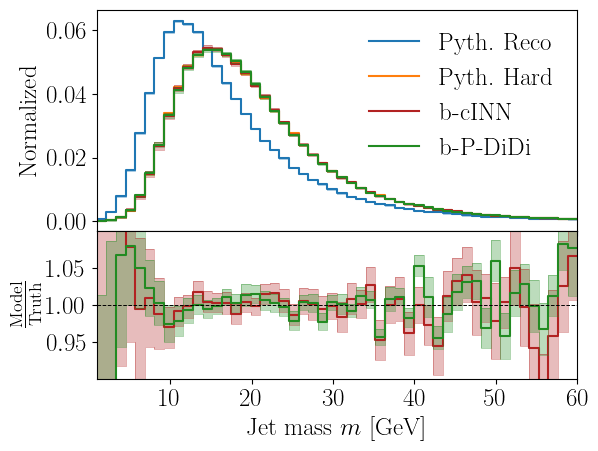

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


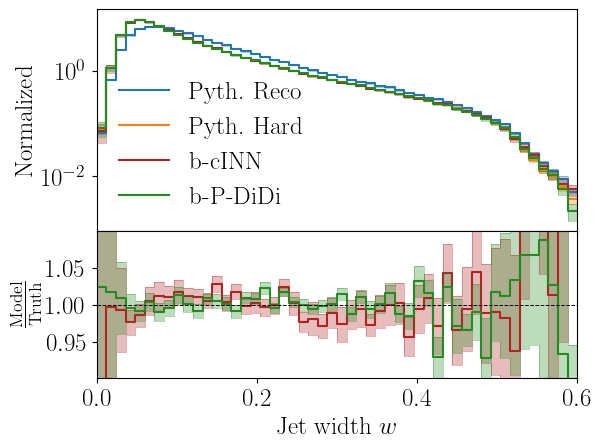

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


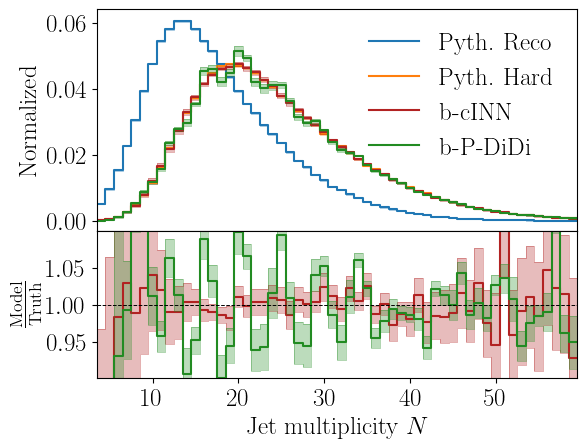

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


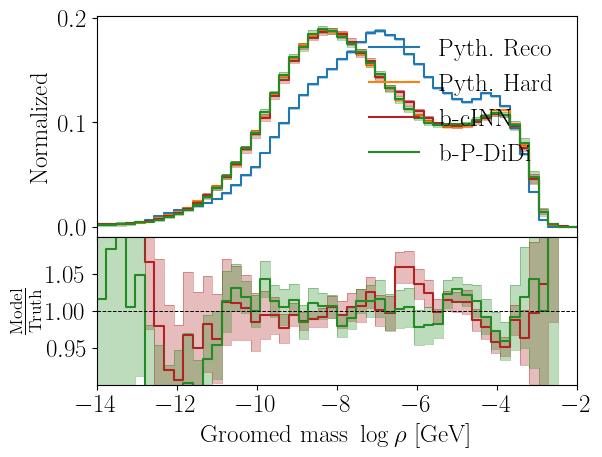

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


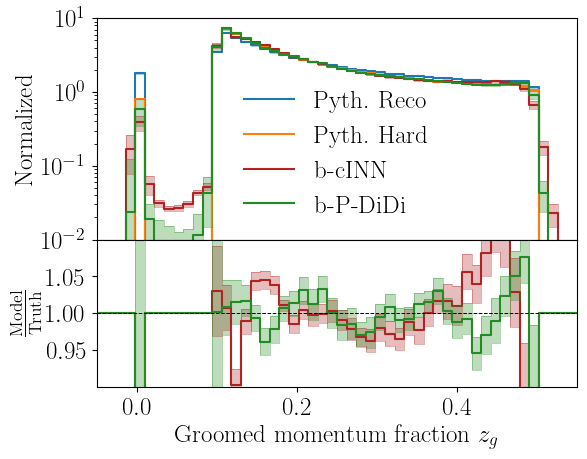

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1


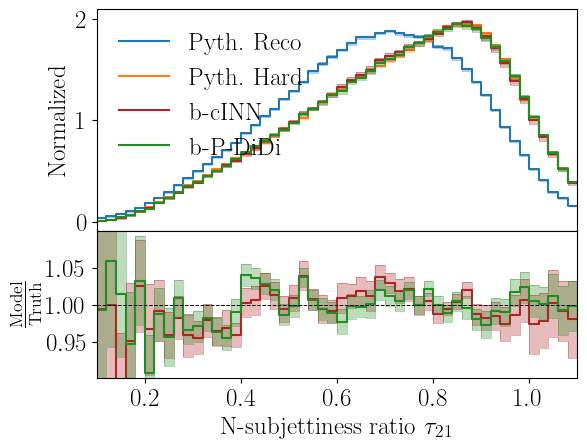

In [360]:
INN_nopreproc = comparison_all[0]
PDIDI_nopreproc = comparison_all[1]

with PdfPages(final_route + "ALL_nopreproc.pdf") as pp:
    for observable_INN, observable_PDIDI in zip(INN_nopreproc, PDIDI_nopreproc):

        # Reco
        line_reco = observable_INN["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_INN["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "b-cINN"
        
        # PDIDI
        obs_PDIDI = observable_PDIDI["obs"]
        bins_PDIDI = observable_PDIDI["bins"]
        line_PDIDI = observable_PDIDI["lines"][3]
        line_PDIDI.color = P_DIDI_COLOR
        line_PDIDI.label = "b-P-DiDi"

        
        # SB
        line_SB = observable_INN["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_PDIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_INN, line_PDIDI],
            bins=bins_INN,
            observable=obs_INN,
            n_unfoldings=1,
            show_ratios=True,
            bayesian=True,
            ylim=ylim,
            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label else "lower center" if "momentum" in obs_INN.tex_label else "upper left" if "subjettines" in obs_INN.tex_label else "best")},
        )

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


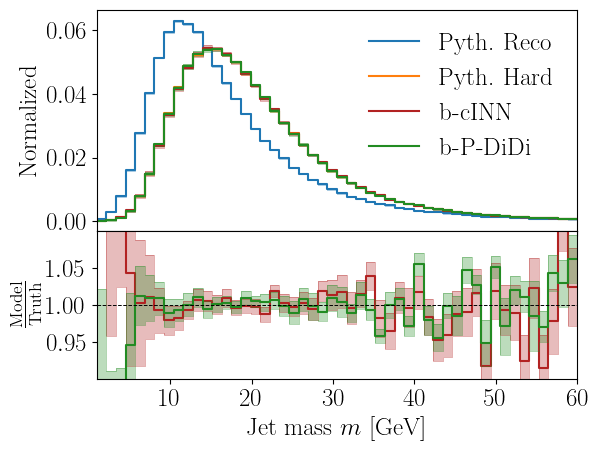

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


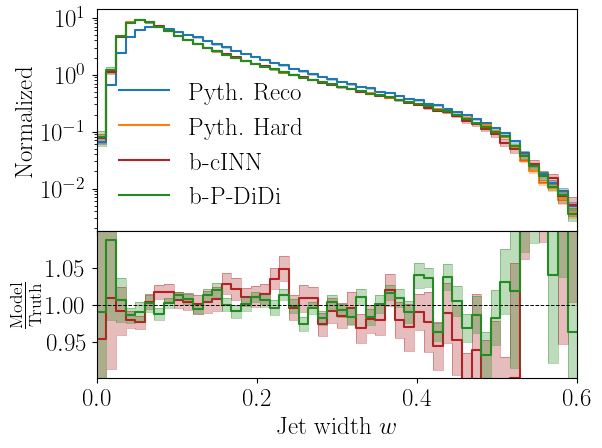

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


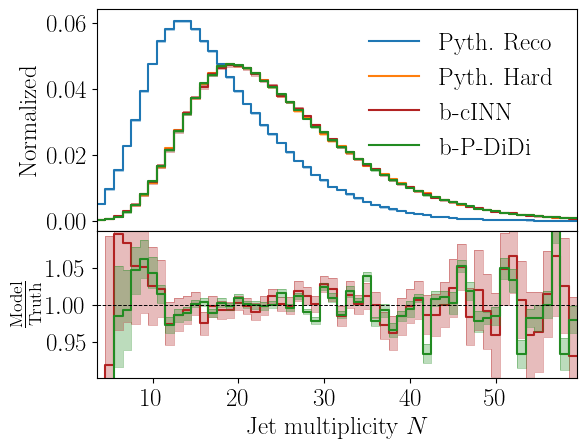

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


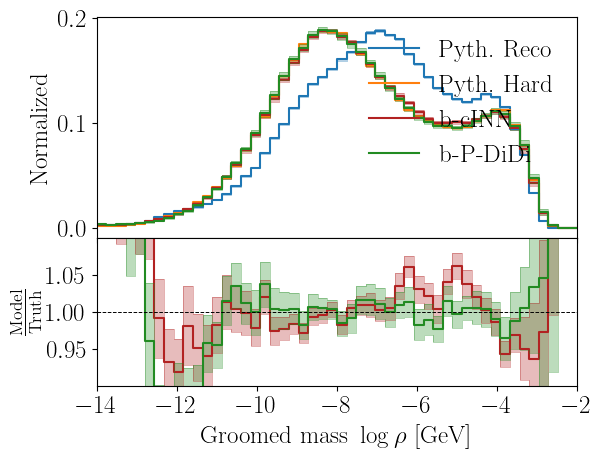

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


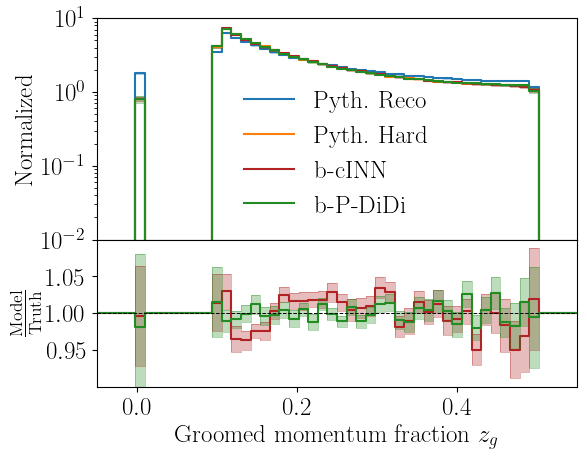

Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1
Weights for Unc. of unfolds 1.0
Weights for Unc. of unfolds 1.0


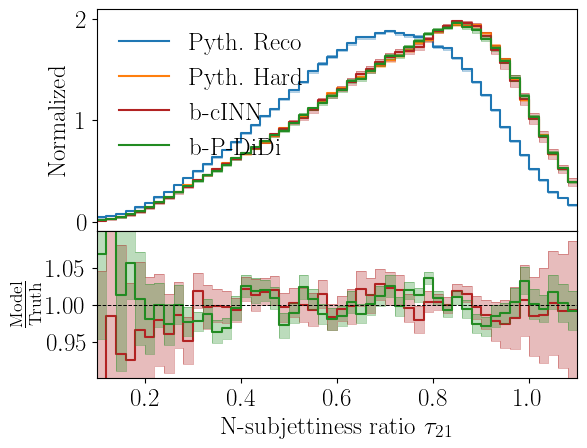

In [361]:
INN_both_preproc = comparison_all[2]
PDIDI_both_preproc = comparison_all[3]

with PdfPages(final_route + "ALL_both_preproc.pdf") as pp:
    for observable_INN, observable_PDIDI in zip(INN_both_preproc, PDIDI_both_preproc):

        # Reco
        line_reco = observable_INN["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_INN["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "b-cINN"
        
        # PDIDI
        obs_PDIDI = observable_PDIDI["obs"]
        bins_PDIDI = observable_PDIDI["bins"]
        line_PDIDI = observable_PDIDI["lines"][3]
        line_PDIDI.color = P_DIDI_COLOR
        line_PDIDI.label = "b-P-DiDi"
        
        # SB
        line_SB = observable_INN["lines"][4]
        line_SB.color = "black"
        ylim = [1e-2, 1e1] if "momentum" in obs_PDIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_INN, line_PDIDI],
            bins=bins_INN,
            observable=obs_INN,
            n_unfoldings=1,
            show_ratios=True,
            ylim=ylim,
            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label else "lower center" if "momentum" in obs_INN.tex_label else "upper left" if "subjettines" in obs_INN.tex_label else "best")},
        )